# #7 : LSE 

In [1]:
library(tidyverse)
library(readr)
library(gridExtra)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --

√ ggplot2 3.1.1       √ purrr   0.3.4  
√ tibble  2.1.1       √ dplyr   0.8.0.1
√ tidyr   0.8.3       √ stringr 1.4.0  
√ readr   1.3.1       √ forcats 0.4.0  

Warning message:
"package 'purrr' was built under R version 3.6.3"
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter()  masks stats::filter()
x purrr::flatten() masks jsonlite::flatten()
x dplyr::lag()     masks stats::lag()

Warning message:
"package 'gridExtra' was built under R version 3.6.3"

Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine




In [2]:
library(repr)

Warning message:
"package 'repr' was built under R version 3.6.3"


## PART 1 : 아파트 가격 예측모형 

* y : 아파트 시세 중간값 (단위 만원); (2000년 7월 서울시 강남구)
* x1 : 건설업체 (정성변수)
* x2 : 도보로 10분이내 지하철 노선 개수
* x3 : 건축년도
* x4 : 평수
* x5 : 단지규모

In [3]:
apt <- read_csv("APT.csv")

apt<- apt %>% select("시세(중간값)","건설업체","지하철","건축년도","평     수","단지규모")
colnames(apt) <- c("y", "x1", "x2", "x3", "x4", "x5")

Parsed with column specification:
cols(
  `시세(하한)` = col_number(),
  `시세(상한)` = col_number(),
  `시세(중간값)` = col_number(),
  건설업체 = col_character(),
  지하철 = col_double(),
  건축년도 = col_double(),
  `평     수` = col_double(),
  단지규모 = col_double(),
  `연     령` = col_double(),
  `지하철1개 노선` = col_double(),
  `지하철 2개노선` = col_double(),
  대기업더미 = col_double()
)



### (a) 독립변수 산점도 및 변수변환 검토

In [4]:
options(repr.plot.width = 15, repr.plot.height = 15)

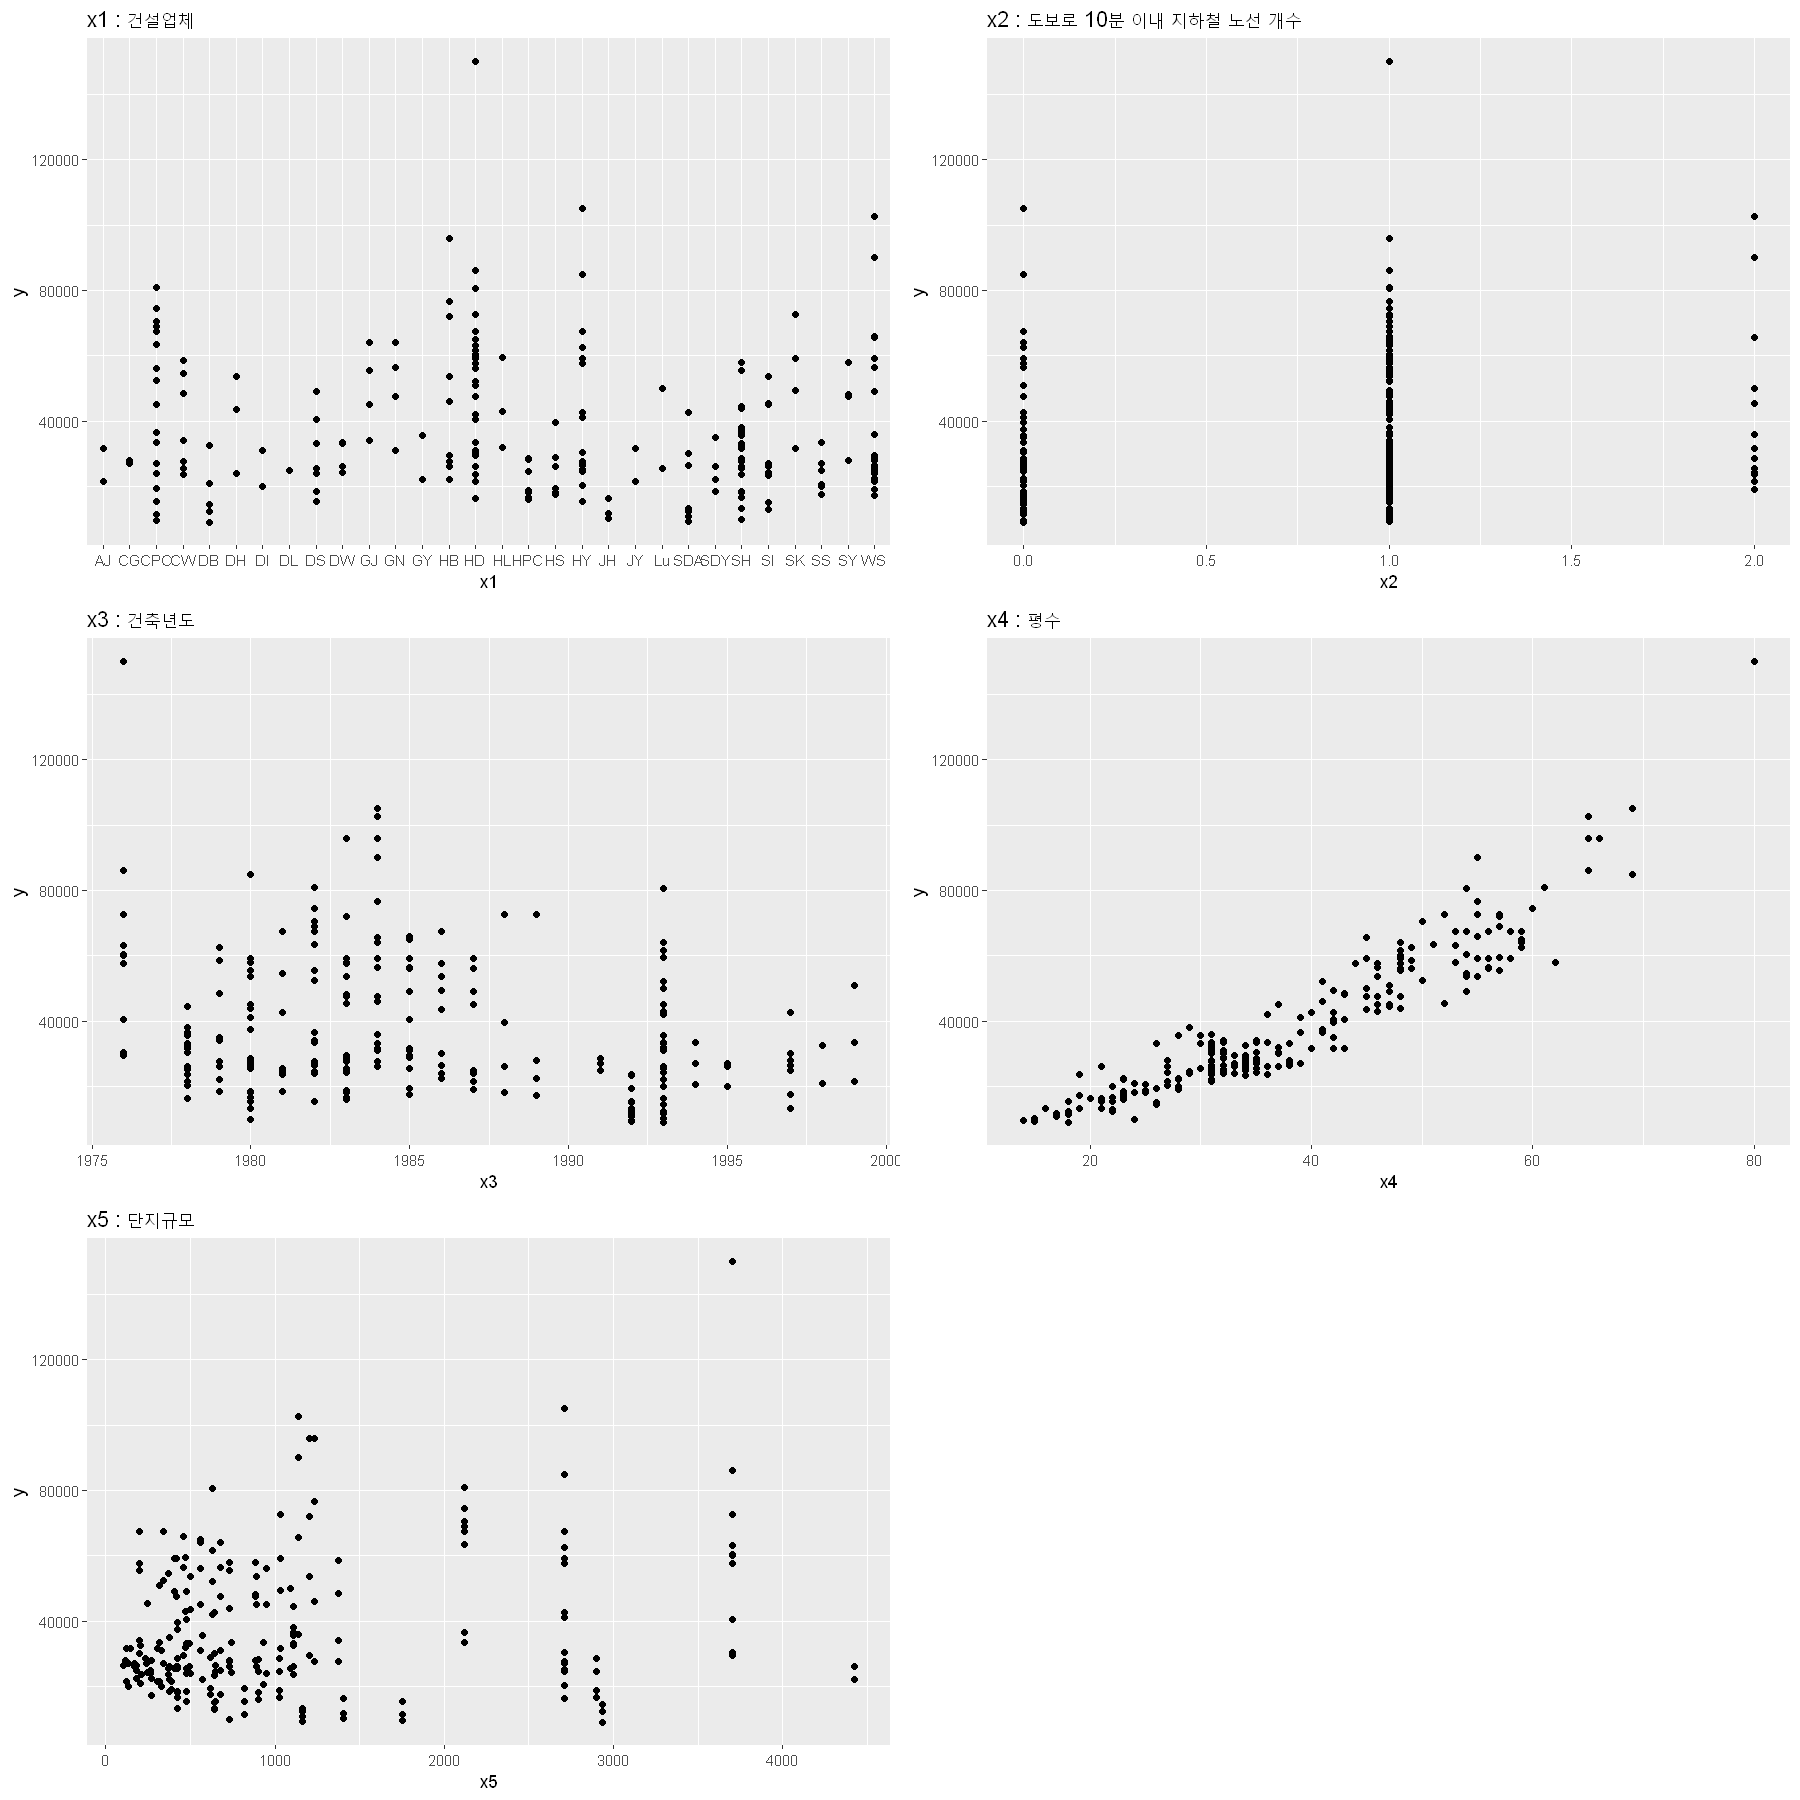

In [5]:
g1 <- ggplot(apt,aes(x1,y))+geom_point()+ggtitle("x1 : 건설업체")
g2 <- ggplot(apt,aes(x2,y))+geom_point()+ggtitle("x2 : 도보로 10분 이내 지하철 노선 개수")
g3 <- ggplot(apt,aes(x3,y))+geom_point()+ggtitle("x3 : 건축년도")
g4 <- ggplot(apt,aes(x4,y))+geom_point()+ggtitle("x4 : 평수")
g5 <- ggplot(apt,aes(x5,y))+geom_point()+ggtitle("x5 : 단지규모")

grid.arrange(g1,g2,g3,g4,g5, ncol=2)

* ($x_{4},y$) 산점도에서 곡선 형태를 나타나고 있기때문에 곡선항을 반영해 주어야 한다 (${x_{4}}^2$) 

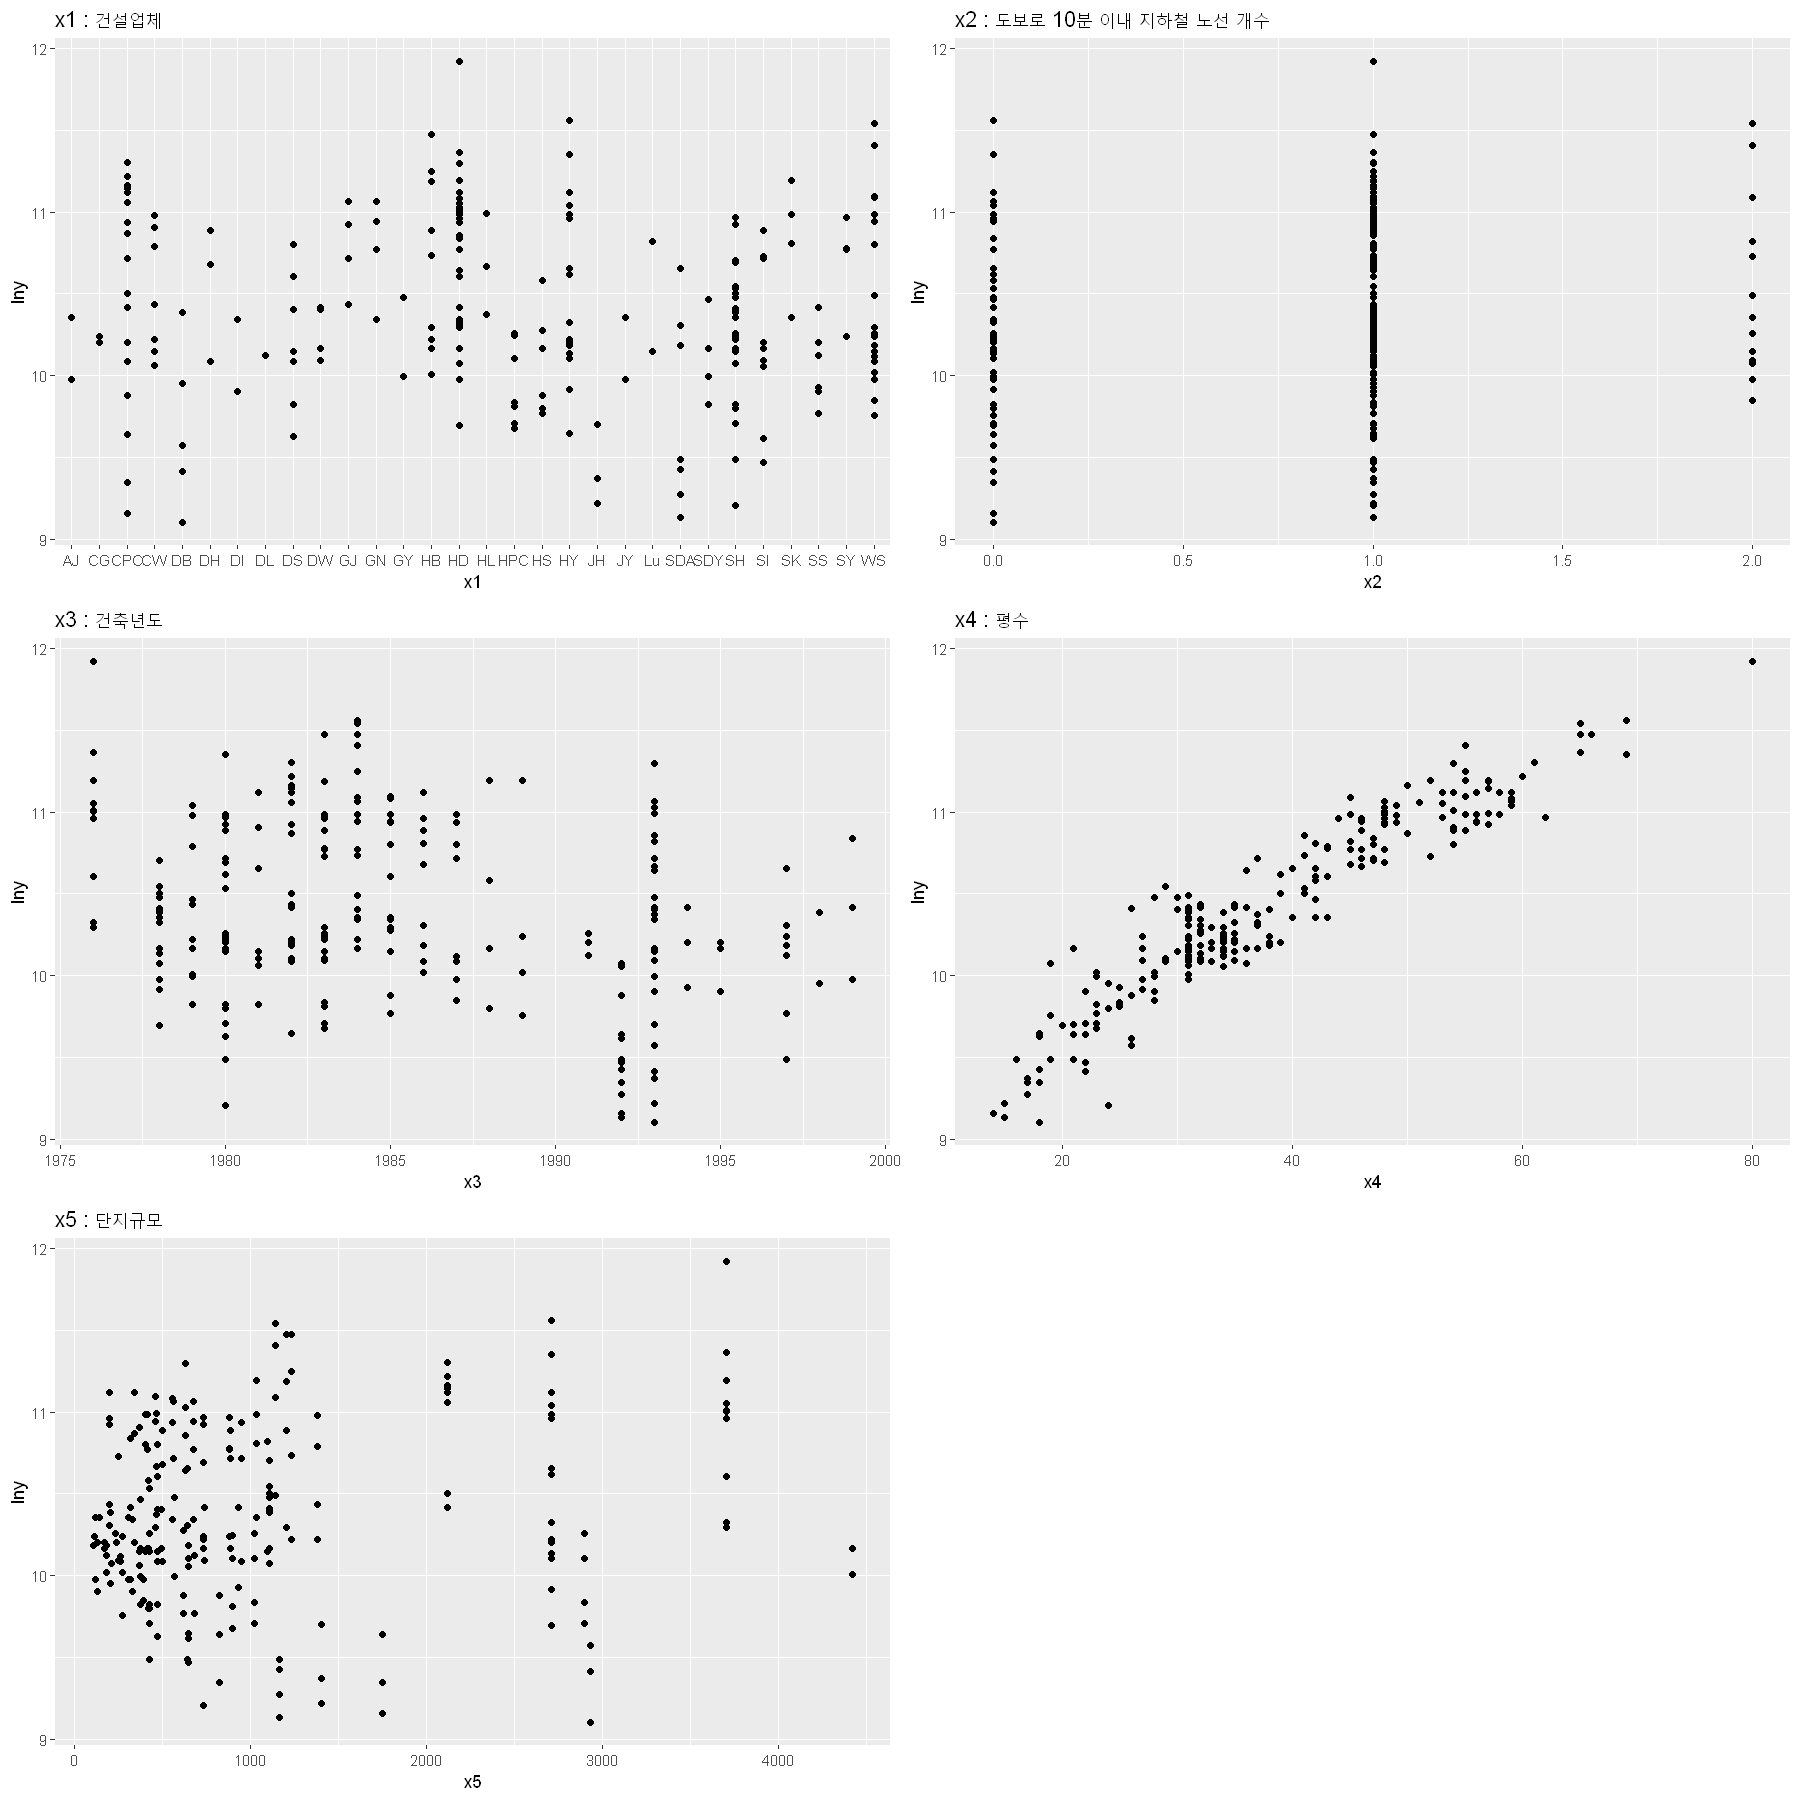

In [6]:
# y -> lny 변환 
apt<-apt[complete.cases(apt),] %>% mutate(lny=log(y))

g1 <- ggplot(apt,aes(x1,lny))+geom_point()+ggtitle("x1 : 건설업체")
g2 <- ggplot(apt,aes(x2,lny))+geom_point()+ggtitle("x2 : 도보로 10분 이내 지하철 노선 개수")
g3 <- ggplot(apt,aes(x3,lny))+geom_point()+ggtitle("x3 : 건축년도")
g4 <- ggplot(apt,aes(x4,lny))+geom_point()+ggtitle("x4 : 평수")
g5 <- ggplot(apt,aes(x5,lny))+geom_point()+ggtitle("x5 : 단지규모")

grid.arrange(g1,g2,g3,g4,g5, ncol=2)

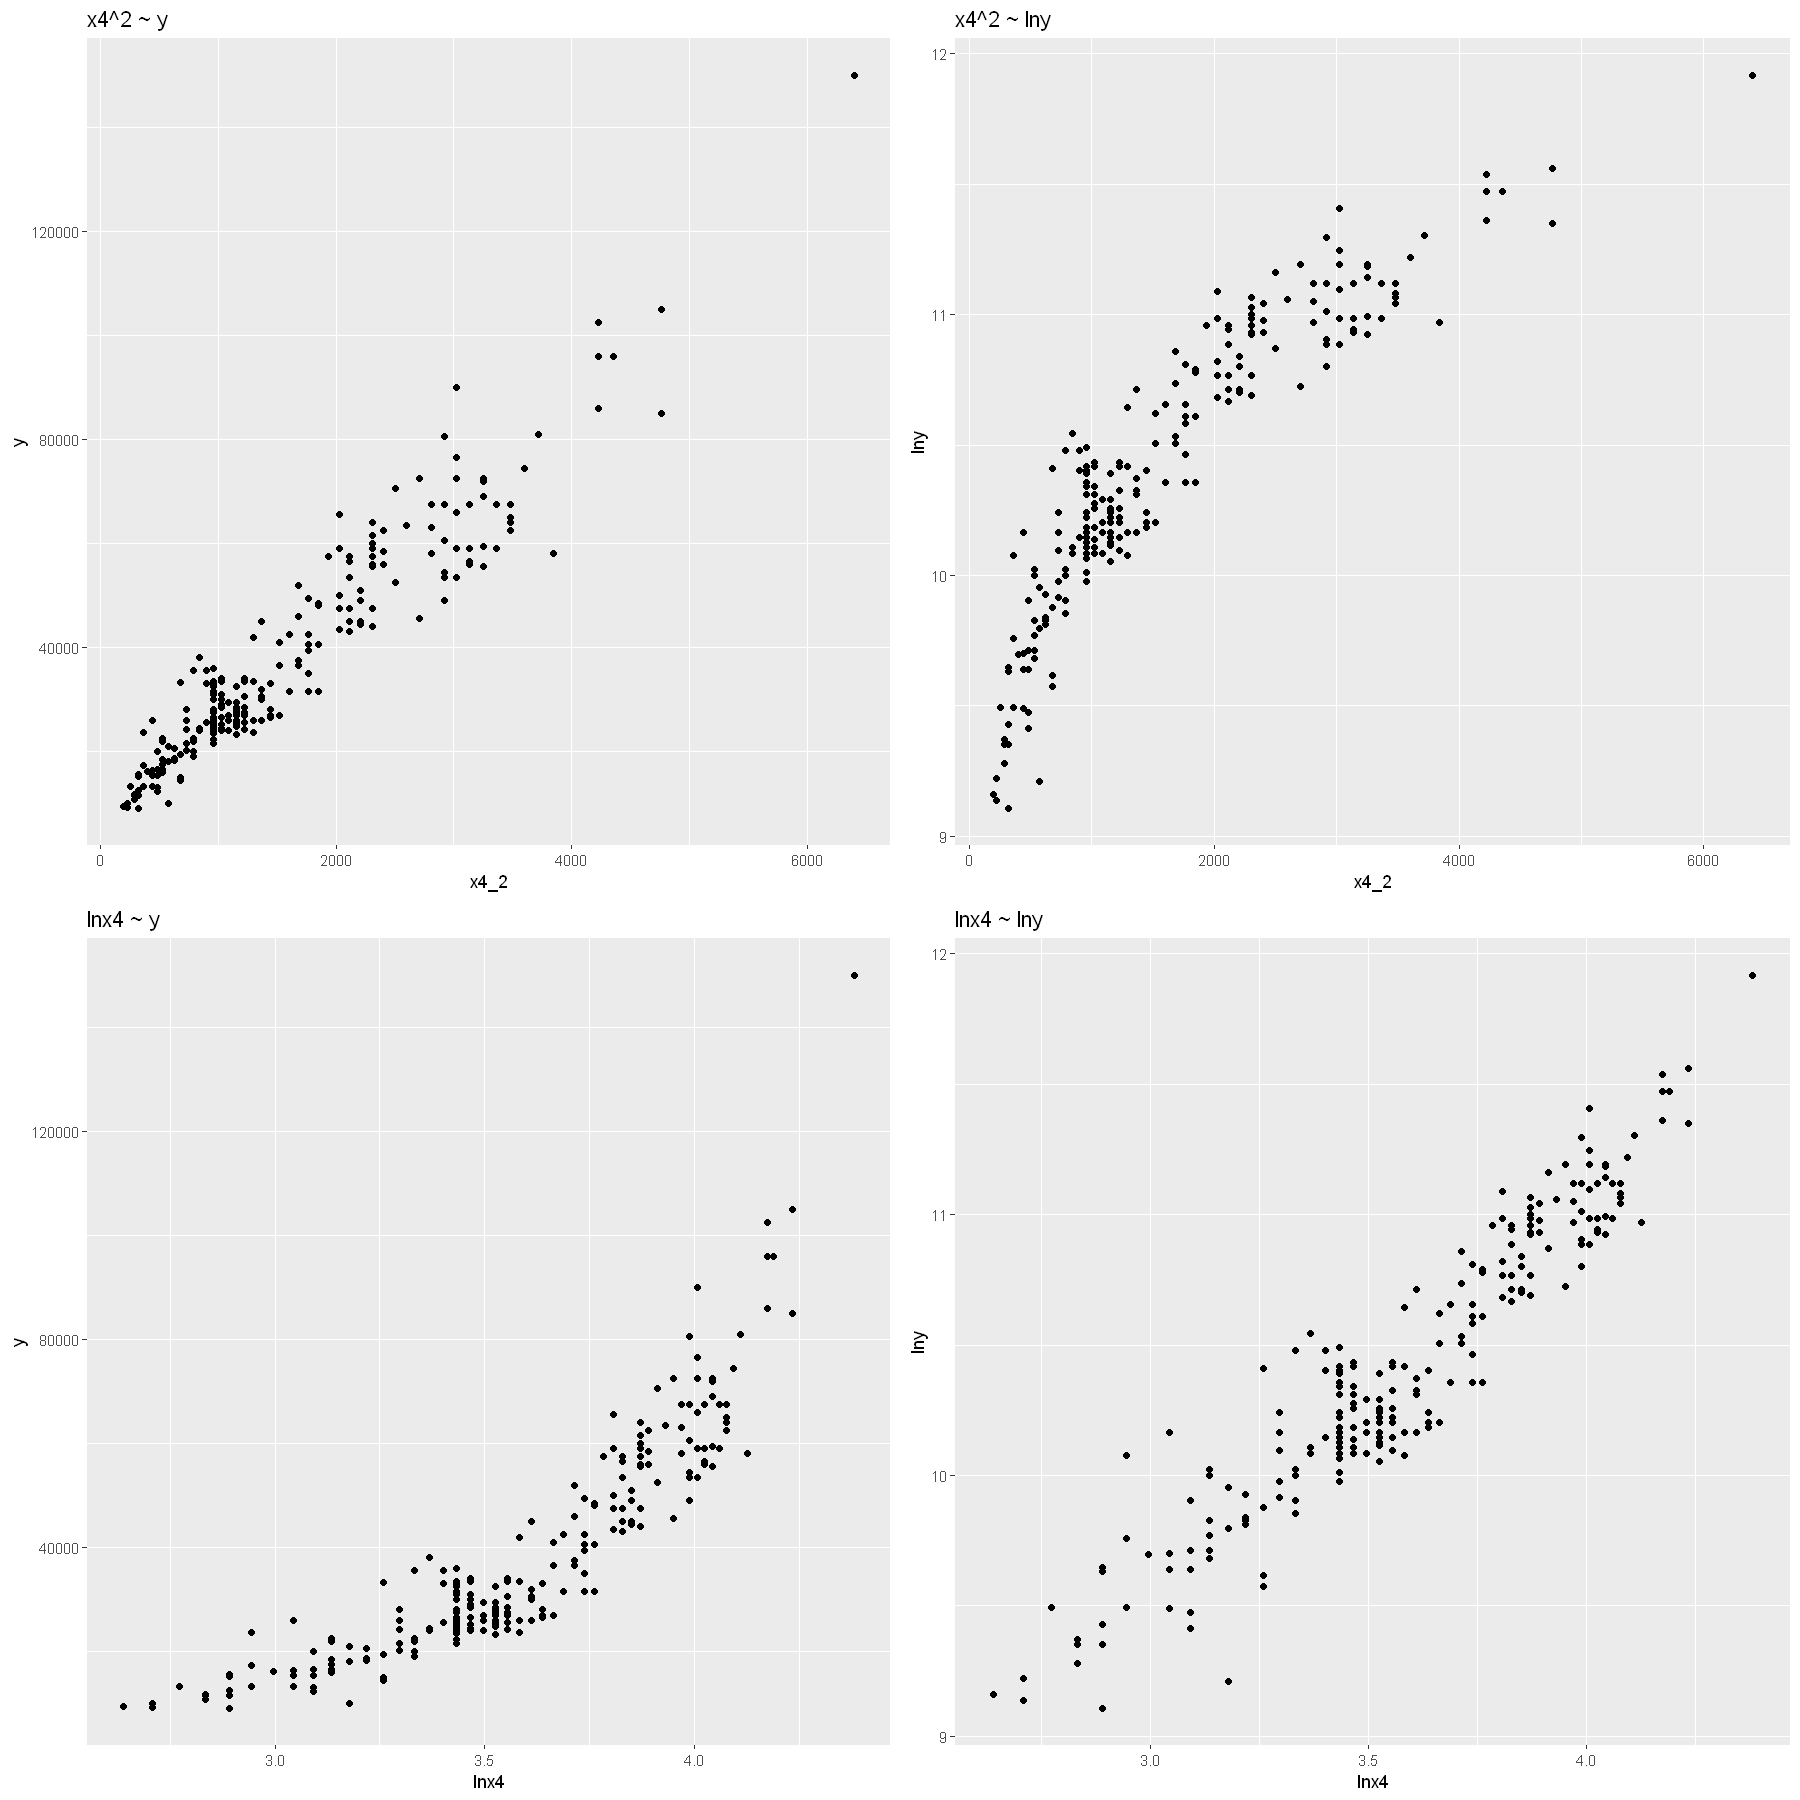

In [7]:
# x4 transform 
apt<-apt[complete.cases(apt),] %>% mutate(x4_2=x4^2, lnx4 = log(x4))

g1 <- ggplot(apt,aes(x4_2,y))+geom_point()+ggtitle("x4^2 ~ y")
g2 <- ggplot(apt,aes(x4_2,lny))+geom_point()+ggtitle("x4^2 ~ lny")
g3 <- ggplot(apt,aes(lnx4,y))+geom_point()+ggtitle("lnx4 ~ y")
g4 <- ggplot(apt,aes(lnx4,lny))+geom_point()+ggtitle("lnx4 ~ lny")

grid.arrange(g1,g2,g3,g4, ncol=2)

* (${x_4}^2, y$), ($lnx_4, y$) 의 산점도를 비교했을 때 linear한 패턴을 보이고 있다.
* 이 두가지 모형을 고려하여 최적 예측모형을 찾아보기로 한다. 

### (b) 최적 가격예측모형 찾기

In [8]:
apt1 <- apt %>% select('y', 'x1','x2','x3','x4_2','x5')
mystep1<-step(glm(y~.^2,data=apt1),direction="backward") # 교호작용 고려 

Start:  AIC=4694.32
y ~ (x1 + x2 + x3 + x4_2 + x5)^2

          Df   Deviance    AIC
- x1:x4_2 28 3129022805 4680.2
- x2:x4_2  1 2621022528 4692.4
- x2:x3    1 2639262968 4694.0
<none>       2620544848 4694.3
- x2:x5    1 2672186283 4696.9
- x3:x4_2  1 2676313853 4697.3
- x1:x2    4 2801580824 4702.1
- x3:x5    1 2822157689 4709.8
- x4_2:x5  1 2856349741 4712.7
- x1:x5    9 3070941073 4713.8
- x1:x3   10 3200849206 4721.5

Step:  AIC=4680.18
y ~ x1 + x2 + x3 + x4_2 + x5 + x1:x2 + x1:x3 + x1:x5 + x2:x3 + 
    x2:x4_2 + x2:x5 + x3:x4_2 + x3:x5 + x4_2:x5

          Df   Deviance    AIC
- x2:x3    1 3155147910 4680.1
<none>       3129022805 4680.2
- x2:x5    1 3196375972 4683.2
- x1:x2    4 3379501121 4690.3
- x3:x4_2  1 3302235948 4690.9
- x3:x5    1 3310790868 4691.5
- x2:x4_2  1 3333154079 4693.1
- x1:x5    9 3621915162 4696.7
- x1:x3   10 3700030692 4699.7
- x4_2:x5  1 3772507191 4722.3

Step:  AIC=4680.14
y ~ x1 + x2 + x3 + x4_2 + x5 + x1:x2 + x1:x3 + x1:x5 + x2:x4_2 + 
    x2:x5 + x3

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"


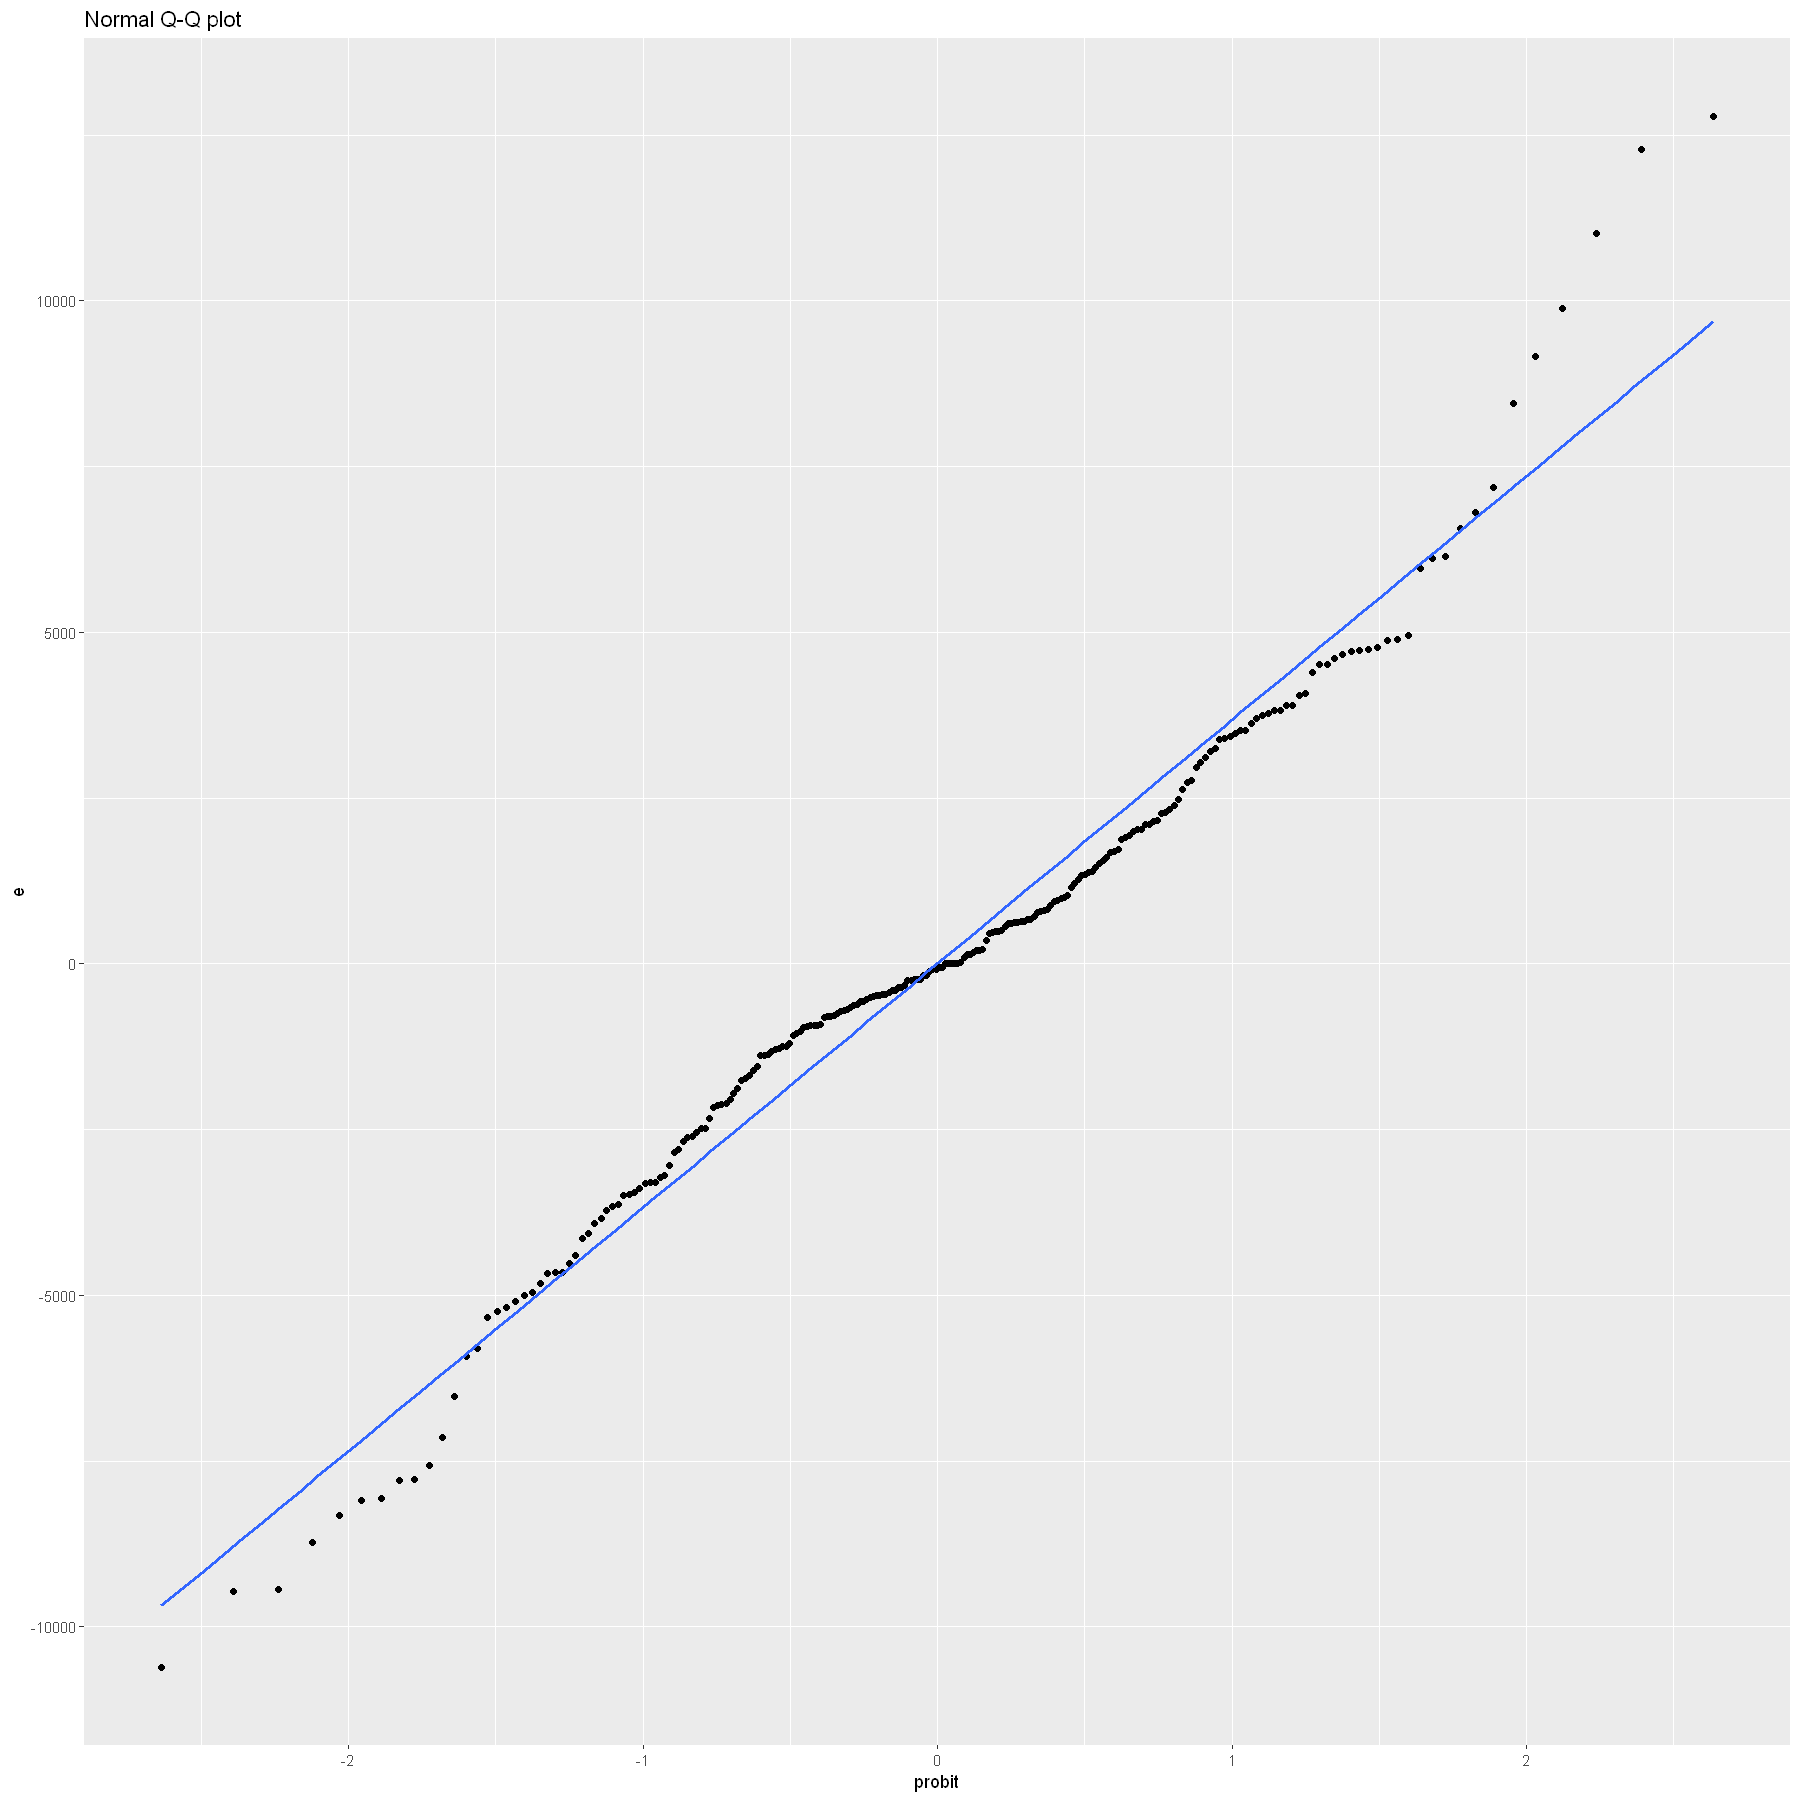

In [9]:
apt1 <- apt1 %>% mutate(ypred=predict(mystep1,apt1),e=y-ypred,r=rank(e),pr=r/(nrow(apt1)+1),probit=qnorm(pr))
ggplot(apt1,aes(probit,e))+geom_point()+geom_smooth(method="lm",se=F)+ggtitle("Normal Q-Q plot")

* y ~ x1 + x2 + x3 + x4_2 + x5 + x1:x2 + x1:x3 + x1:x5 + x2:x4_2 + x2:x5 + x3:x4_2 + x3:x5 + x4_2:x5
* 직선과 많이 떨어져 있는 형태를 보인다.

### (c) lny 최적 가격예측모형 찾기

In [10]:
apt2 <- apt %>% select('lny', 'x1','x2','x3','lnx4','x5')
mystep2<-step(glm(lny~.^2,data=apt2),direction="backward") # 교호작용 고려 

Start:  AIC=-307.03
lny ~ (x1 + x2 + x3 + lnx4 + x5)^2

          Df Deviance     AIC
- x1:lnx4 28   1.9827 -318.19
- x3:lnx4  1   1.6411 -308.82
- x2:x3    1   1.6412 -308.81
- x2:x5    1   1.6422 -308.66
- x2:lnx4  1   1.6508 -307.43
<none>         1.6396 -307.03
- lnx4:x5  1   1.6641 -305.53
- x3:x5    1   1.8209 -284.28
- x1:x2    4   1.9762 -270.97
- x1:x3   10   2.1446 -263.67
- x1:x5    9   2.1827 -257.51

Step:  AIC=-318.19
lny ~ x1 + x2 + x3 + lnx4 + x5 + x1:x2 + x1:x3 + x1:x5 + x2:x3 + 
    x2:lnx4 + x2:x5 + x3:lnx4 + x3:x5 + lnx4:x5

          Df Deviance     AIC
- x3:lnx4  1   1.9837 -320.07
- x2:lnx4  1   1.9873 -319.65
- x2:x3    1   1.9874 -319.63
- x2:x5    1   1.9935 -318.91
<none>         1.9827 -318.19
- lnx4:x5  1   2.1165 -304.78
- x3:x5    1   2.1616 -299.81
- x1:x2    4   2.3927 -281.83
- x1:x3   10   2.6120 -273.14
- x1:x5    9   2.5913 -273.02

Step:  AIC=-320.07
lny ~ x1 + x2 + x3 + lnx4 + x5 + x1:x2 + x1:x3 + x1:x5 + x2:x3 + 
    x2:lnx4 + x2:x5 + x3:x5 + lnx

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"


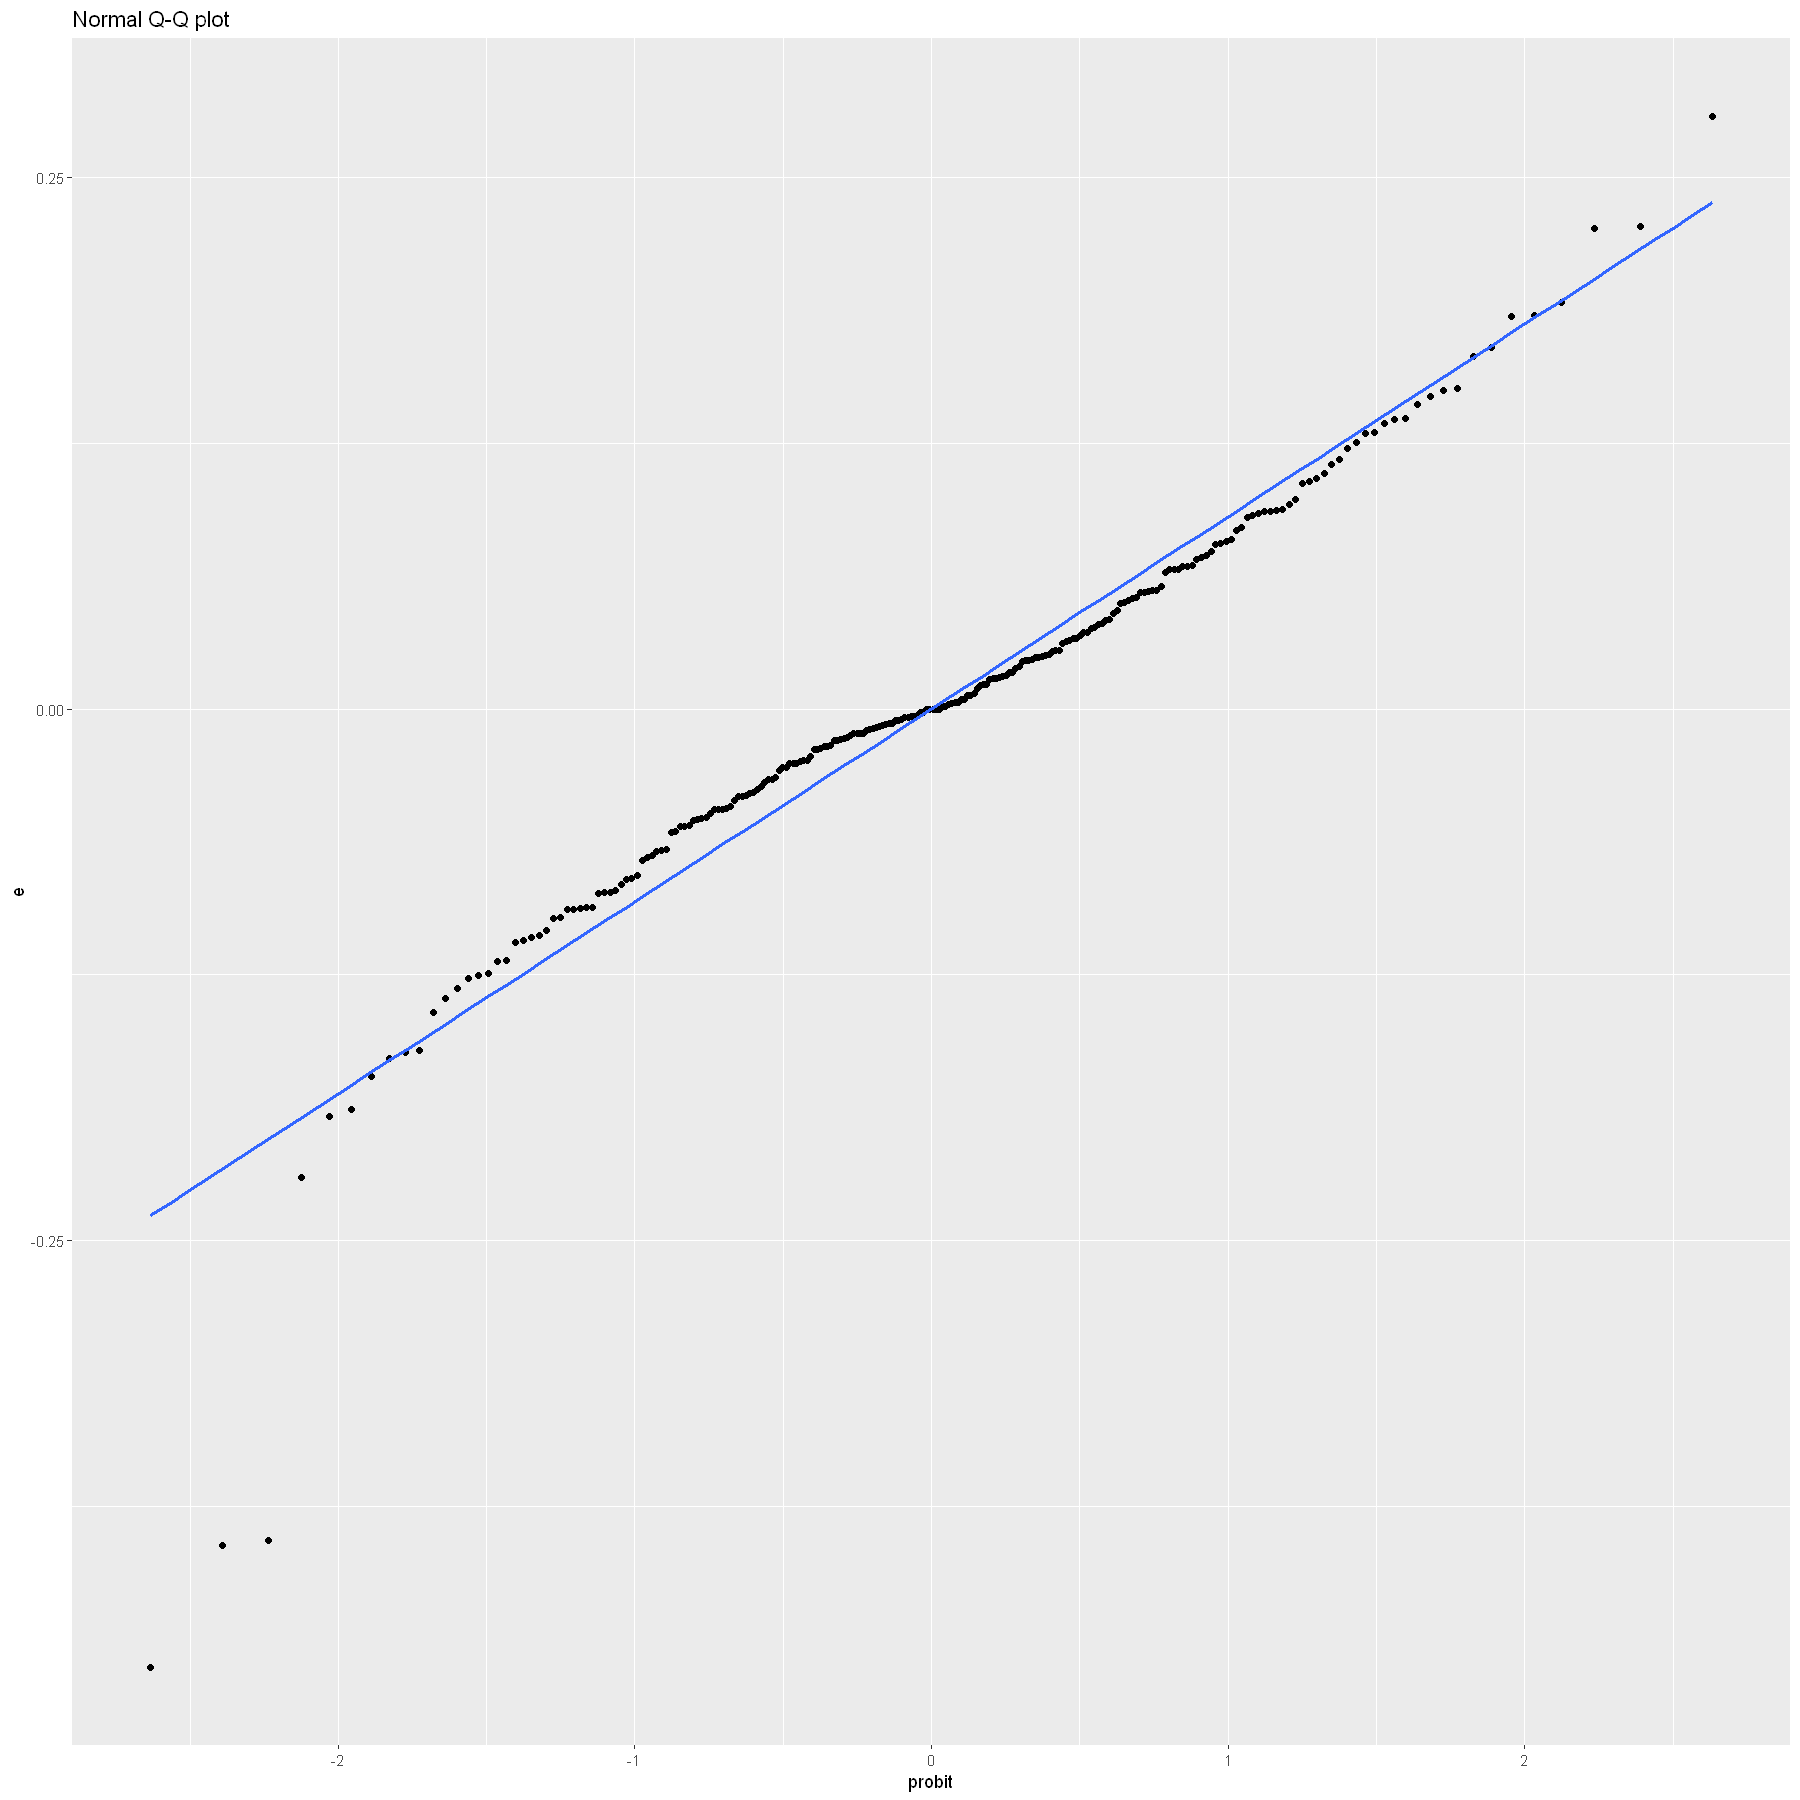

In [11]:
apt2 <- apt2 %>% mutate(ypred=predict(mystep2,apt2),e=lny-ypred,r=rank(e),pr=r/(nrow(apt2)+1),probit=qnorm(pr))
ggplot(apt2,aes(probit,e))+geom_point()+geom_smooth(method="lm",se=F)+ggtitle("Normal Q-Q plot") 

* lny ~ x1 + x2 + x3 + lnx4 + x5 + x1:x2 + x1:x3 + x1:x5 + x3:x5 + lnx4:x5
* 위의 모형보다 직선에 훨씬 가까워진 것을 볼 수 있다. -> 정규성 가정을 만족한다. 

### (d) AIC 비교 및 변수 효과 설명 

In [12]:
AIC1<-mystep1$aic
AIC2<-mystep2$aic+2*sum(apt$lny)
AIC1; AIC2

[1] 4680.138

[1] 4580.971

* lny로 적합시킨 모형이 AIC 값이 더 작으므로 적절하다고 할 수 있다. 
* lny ~ x1 + x2 + x3 + lnx4 + x5 + x1:x2 + x1:x3 + x1:x5 + x3:x5 + lnx4:x5
* 아파트 가격은 건설업체, 지하철 노선 개수, 건축년도, log(평수), 단지 규모에 영향을 받으며,     
  건설업체와 단지규모 사이의 교호작용, 건축년도와 단지규모 사이의 교호작용, 평수와 단지규모 사이의 교호작용 또한 영향을 준다. 

## PART 2 : Antoine equation / NLSE

* $p_i$ : Saturated Vapor pressure (포화증기압) (mmHg)
* $T_i$ : Absolute Temperature (비등점에서 물의 절대온도/ 증기온도)      
  (절대온도 K = 273.15 + 섭씨온도 C)
  

* Objective: 비등점에서의 물의온도(T)와 증기압(p) 사이의 관계를 나타내는 함수식을 찾는다.


* **Antoine equation** : $lnp_i = a + b/(T_i-c) + e_i$ (Non-linear Regession Model)
* 모수 : $\theta = (a,b,c)$

In [13]:
antoine<-read.csv("Antoine.csv", header=T)
colnames(antoine) <- c("temp", "temp.K", "pressure")

### (a) 산점도
* ($p_i$, $T_i$) 
* ($lnp_i$, $T_i$) 
* ($lnp_i$, 1/$T_i$) 

In [15]:
options(repr.plot.width = 10, repr.plot.height = 10)

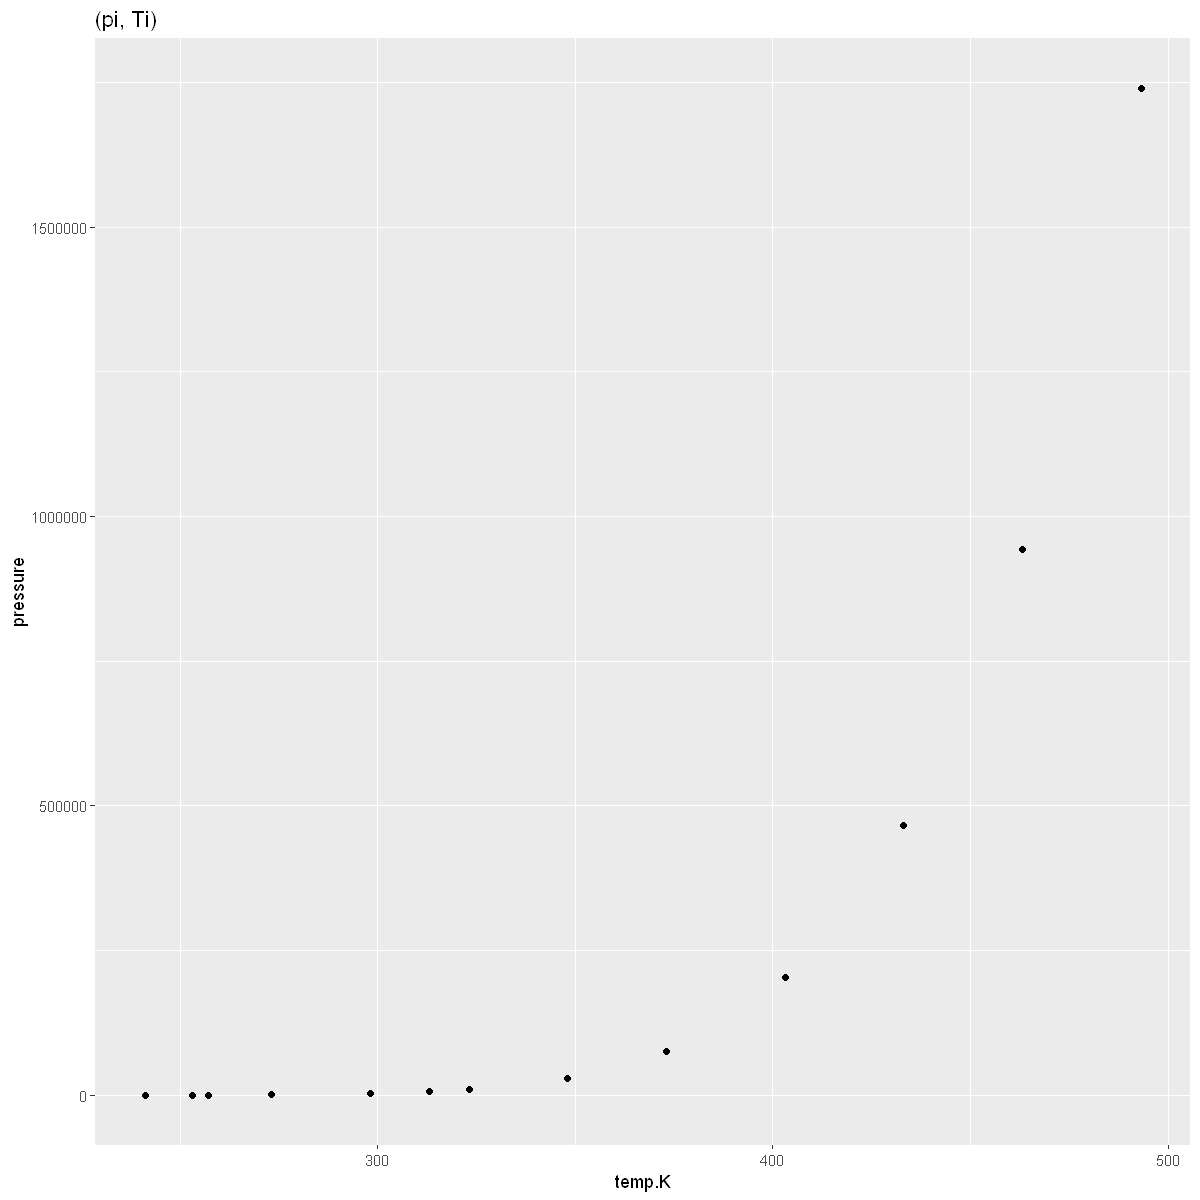

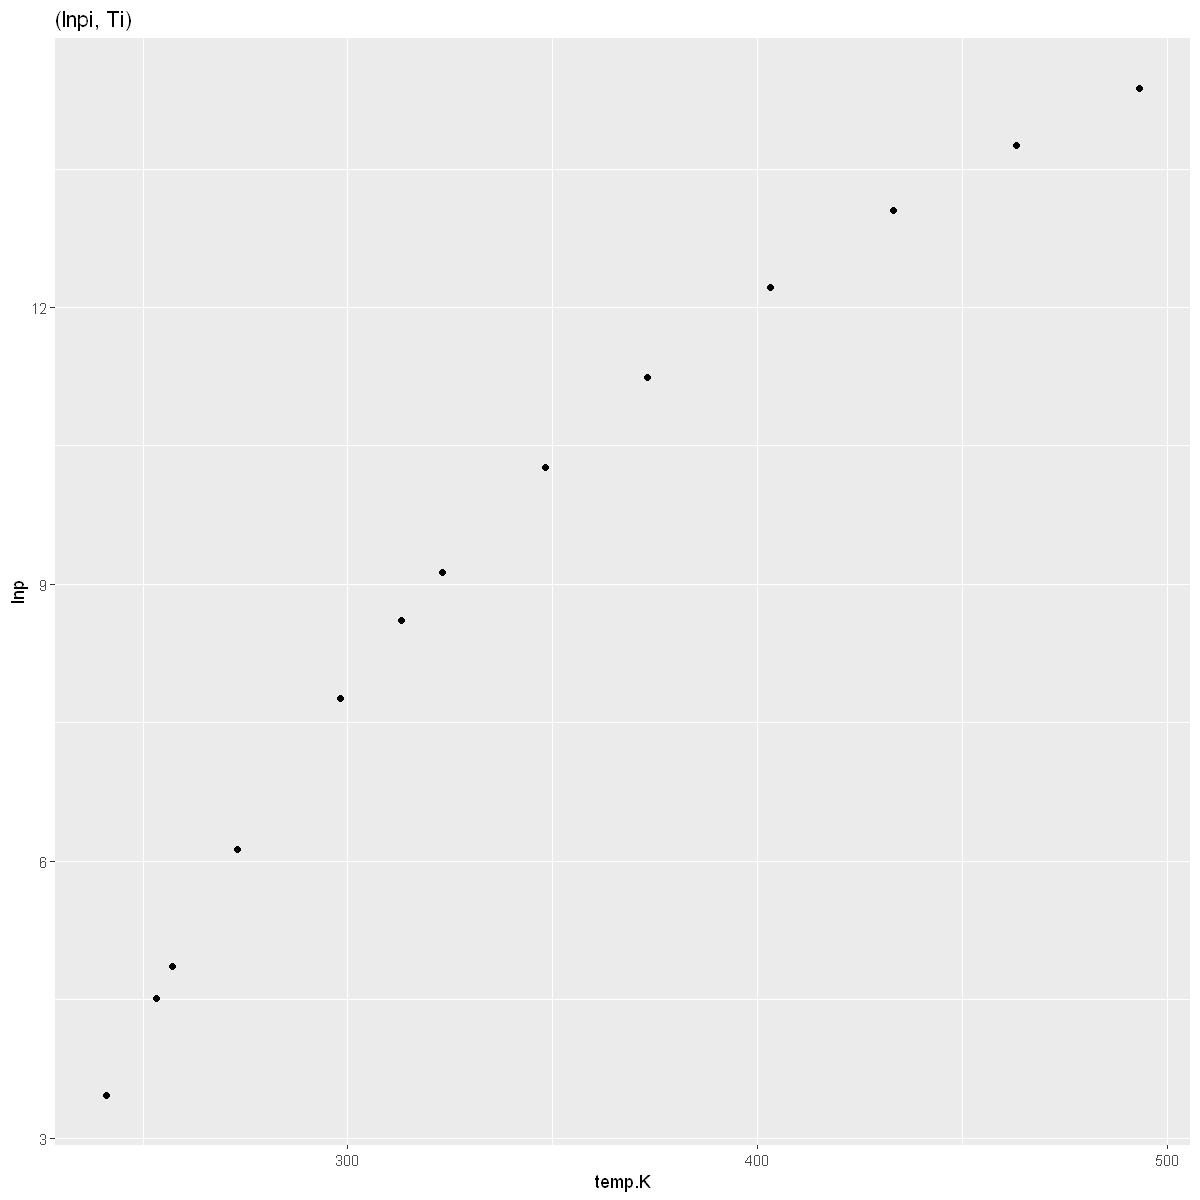

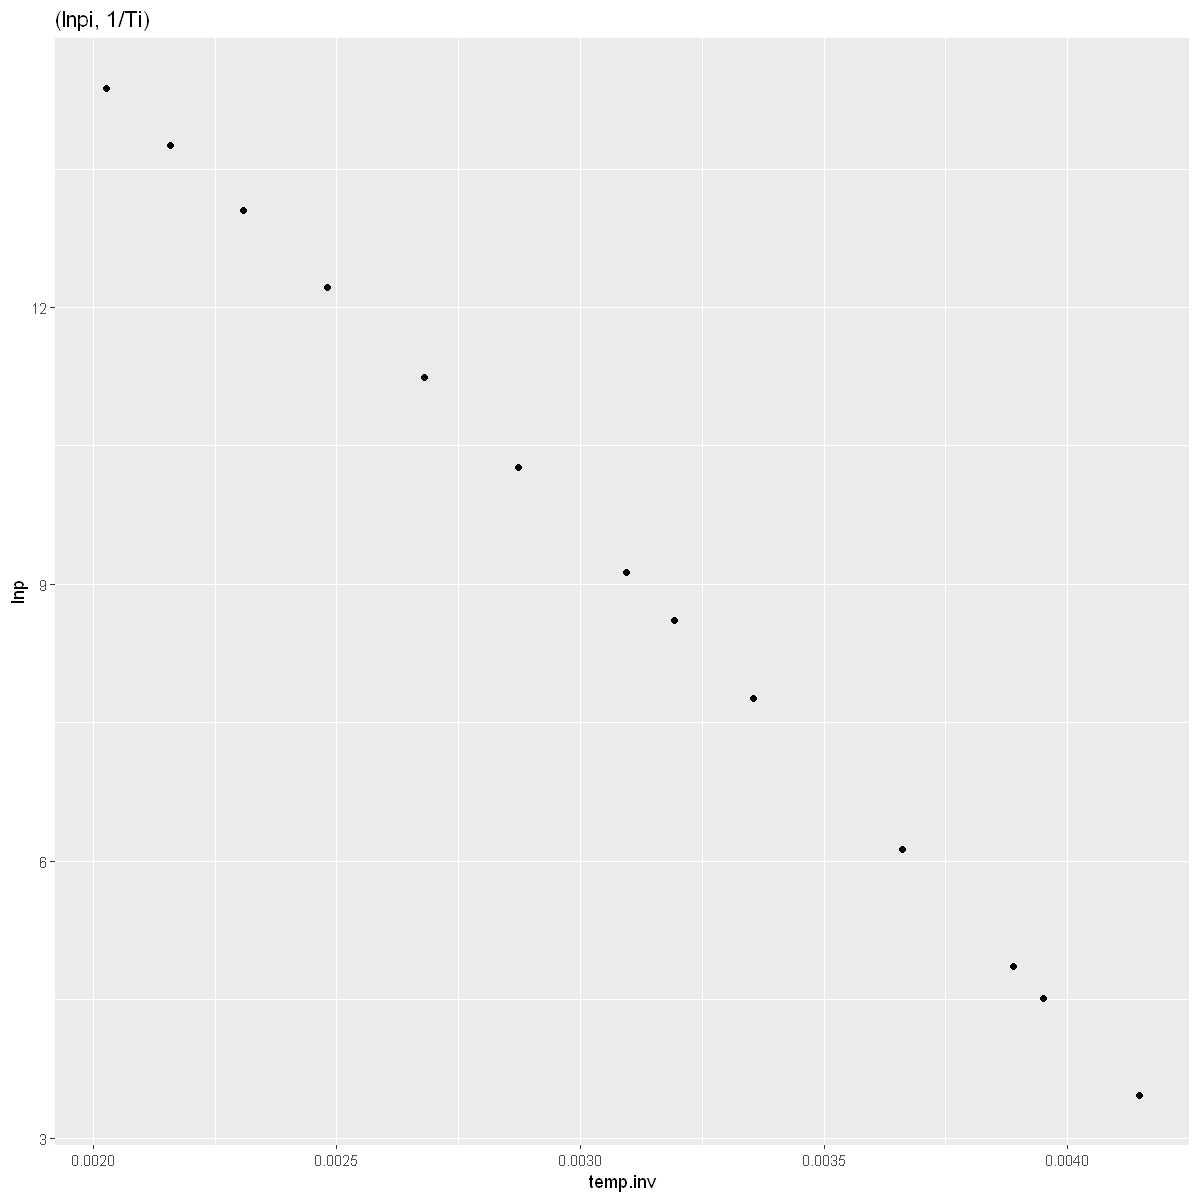

In [16]:
antoine <- antoine %>% transmute(temp=temp,temp.K=temp.K,pressure=pressure,lnp=log(pressure),temp.inv=1/temp.K)
ggplot(antoine,aes(temp.K,pressure))+geom_point()+ggtitle("(pi, Ti)")
ggplot(antoine,aes(temp.K,lnp))+geom_point()+ggtitle("(lnpi, Ti)")
ggplot(antoine,aes(temp.inv,lnp))+geom_point()+ggtitle("(lnpi, 1/Ti)")

### (b) Antoine equation 모수 추정 

#### 방법1 : 단순선형모형

In [17]:
# c=-10,0,10,20,30,40,50 일 때, 단순선형모형 적합하여 MSE 최소화시키는 c값 찾기 
c<-seq(-10,50,by=10)
mse<-c()

for (i in 1:length(c)) {
  mylm<-lm(lnp~I(1/(temp.K-c[i])),data=antoine)
  mypred<-predict(mylm,antoine)
  mse[i]<-mean((antoine$lnp-mypred)^2)
}

chat<-c[which.min(mse)]
lm1<-lm(lnp~I(1/(temp.K-chat)),data=antoine)
ahat<-summary(lm1)$coefficients[1]
bhat<-summary(lm1)$coefficients[2]
cbind(ahat,bhat,chat)

ahat,bhat,chat
23.11929,-3961.215,40


In [20]:
library(optimx)

Warning message:
"package 'optimx' was built under R version 3.6.3"


In [21]:
# r = Corr(lnp, 1/(T-c))를 최대화하는 c값 찾기 
myfunc<-function(c) {
  return(abs(cor(antoine$lnp,1/(antoine$temp.K-c))))
}

result<-optimx(par=chat,myfunc,control=list(maximize=T,trace=0,save.failures=T,all.methods=T))
result

Maximizing -- use negfn and neggr


Warning message in optim(par = par, fn = ufn, gr = ugr, method = meth, control = mcontrol, :
"one-dimensional optimization by Nelder-Mead is unreliable:
use "Brent" or optimize() directly"


,p1,value,fevals,gevals,niter,convcode,kkt1,kkt2,xtime
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<dbl>
BFGS,40.00000,9.999909e-01,2,1,NA,0,TRUE,TRUE,0.00
CG,40.00000,9.999909e-01,1,1,NA,0,TRUE,TRUE,0.00
Nelder-Mead,39.00000,9.999913e-01,10,NA,NA,0,TRUE,TRUE,0.00
L-BFGS-B,38.89796,9.999913e-01,4,4,NA,0,TRUE,TRUE,0.00
nlm,40.00000,9.999909e-01,NA,NA,1,0,TRUE,TRUE,0.00
nlminb,40.00000,9.999909e-01,3,5,2,0,TRUE,TRUE,0.00
spg,NA,-8.988466e+307,NA,NA,NA,9999,NA,NA,0.00
ucminf,NA,-8.988466e+307,NA,NA,NA,9999,NA,NA,0.00
Rcgmin,39.03293,9.999913e-01,224,237,NA,0,TRUE,TRUE,0.03


In [22]:
chat_optim<-result[4,1]

lm_optim<-lm(lnp~I(1/(temp.K-chat_optim)),data=antoine)
ahat_optim<-summary(lm_optim)$coefficients[1]
bhat_optim<-summary(lm_optim)$coefficients[2]
cbind(ahat_optim,bhat_optim,chat_optim)

ahat_optim,bhat_optim,chat_optim
23.17154,-3992.471,38.89796


#### 방법 2: Gauss-Newton Algorithm 

In [23]:
# step1 : 초기값 구하기 
lm2<-lm(lnp~temp.inv+I(lnp/temp.K),data=antoine)
lm2


Call:
lm(formula = lnp ~ temp.inv + I(lnp/temp.K), data = antoine)

Coefficients:
  (Intercept)       temp.inv  I(lnp/temp.K)  
        23.16       -4891.55          39.22  


In [24]:
alphahat<-summary(lm2)$coefficients[1]
betahat<-summary(lm2)$coefficients[2]
gammahat<-summary(lm2)$coefficients[3]

a_initial<-alphahat
b_initial<-betahat+alphahat*gammahat
c_initial<-gammahat
cbind(a_initial,b_initial,c_initial)

a_initial,b_initial,c_initial
23.15636,-3983.349,39.22016


In [25]:
# step2 : Gauss-Newton Algorithm 
abc<-matrix(c(a_initial,b_initial,c_initial,rep(0,3*4)),byrow=T,ncol=3)

for (i in 2:5) {
  col1<-rep(1,nrow(antoine))
  col2<-1/(antoine$temp.K-abc[i-1,3])
  col3<-abc[i-1,2]/((antoine$temp.K-abc[i-1,3])^2)
  X<-cbind(col1,col2,col3)
  z<-antoine$lnp-(abc[i-1,1]+abc[i-1,2]/(antoine$temp.K-abc[i-1,3]))
  beta<-solve(t(X)%*%X)%*%t(X)%*%z
  abc[i,]<-abc[i-1,]+beta
}

beta; abc; 

nlse<-abc[5,]

col1,-2.318388e-09
col2,1.389535e-06
col3,4.891184e-08


23.15636,-3983.349,39.22016
23.17161,-3992.508,38.89648
23.17154,-3992.471,38.89796
23.17154,-3992.471,38.89795
23.17154,-3992.471,38.89795


In [26]:
#step3
antoine<-antoine %>% mutate(yhat=nlse[1]+nlse[2]/(temp.K-nlse[3]),s=(lnp-yhat)^2)
sigma2<-sum(antoine$s)/(nrow(antoine)-3)
sigma<-sqrt(sigma2)
nlse; sigma; sigma2

[1]    23.17154 -3992.47090    38.89795

[1] 0.0168125

[1] 0.0002826602

### (c) NLSE 

In [27]:
mynls<-nls(lnp~a+b*(1/(temp.K-c)),data=antoine,start=list(a=a_initial,b=b_initial,c=c_initial))
mynls

Nonlinear regression model
  model: lnp ~ a + b * (1/(temp.K - c))
   data: antoine
       a        b        c 
   23.17 -3992.47    38.90 
 residual sum-of-squares: 0.002827

Number of iterations to convergence: 2 
Achieved convergence tolerance: 1.055e-06

In [28]:
a_nls<-summary(mynls)$coefficients[1,1]
b_nls<-summary(mynls)$coefficients[2,1]
c_nls<-summary(mynls)$coefficients[3,1]

antoine<-antoine %>% mutate(yhat_nls=a_nls+b_nls/(temp.K-c_nls),s_nls=(lnp-yhat_nls)^2)
sigma2_nls<-sum(antoine$s_nls)/(nrow(antoine)-3)
sigma_nls<-sqrt(sigma2_nls)
c(a_nls,b_nls,c_nls); sigma_nls; sigma2_nls

[1]    23.17154 -3992.47072    38.89796

[1] 0.0168125

[1] 0.0002826602

In [29]:
cbind(ahat,bhat,chat) ; 
cbind(ahat_optim,bhat_optim,chat_optim) ; 
nlse ; 
c(a_nls,b_nls,c_nls)

ahat,bhat,chat
23.11929,-3961.215,40


ahat_optim,bhat_optim,chat_optim
23.17154,-3992.471,38.89796


[1]    23.17154 -3992.47090    38.89795

[1]    23.17154 -3992.47072    38.89796

단순선형모형을 이용하여 모수를 추정한 경우를 제외하고는, 나머지 세 개의 값이 모두 동일하게 나온다. 

### (d) Steam Table (p,T)

In [30]:
T.C<-seq(0,370,by=10)
T.K<-T.C+273.15

P_SLR<-exp(ahat+bhat/(T.K-chat))
P_Corr<-exp(ahat_optim+bhat_optim/(T.K-chat_optim))
P_Gauss<-exp(nlse[1]+nlse[2]/(T.K-nlse[3]))
P_nls<-exp(a_nls+b_nls/(T.K-c_nls))

data<-tibble(T.K,T.C,P_SLR,P_Corr,P_Gauss,P_nls)
data.frame(data)

T.K,T.C,P_SLR,P_Corr,P_Gauss,P_nls
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
273.15,0,4.591159e+02,4.585454e+02,4.585454e+02,4.585454e+02
283.15,10,9.233862e+02,9.213517e+02,9.213517e+02,9.213518e+02
293.15,20,1.757396e+03,1.752389e+03,1.752389e+03,1.752389e+03
303.15,30,3.185036e+03,3.174710e+03,3.174710e+03,3.174710e+03
313.15,40,5.526504e+03,5.507535e+03,5.507535e+03,5.507535e+03
323.15,50,9.223193e+03,9.191293e+03,9.191293e+03,9.191293e+03
333.15,60,1.486404e+04,1.481421e+04,1.481421e+04,1.481421e+04
343.15,70,2.321234e+04,2.313946e+04,2.313946e+04,2.313946e+04
353.15,80,3.523202e+04,3.513192e+04,3.513192e+04,3.513192e+04


In [31]:
options(repr.plot.width = 15, repr.plot.height = 10)

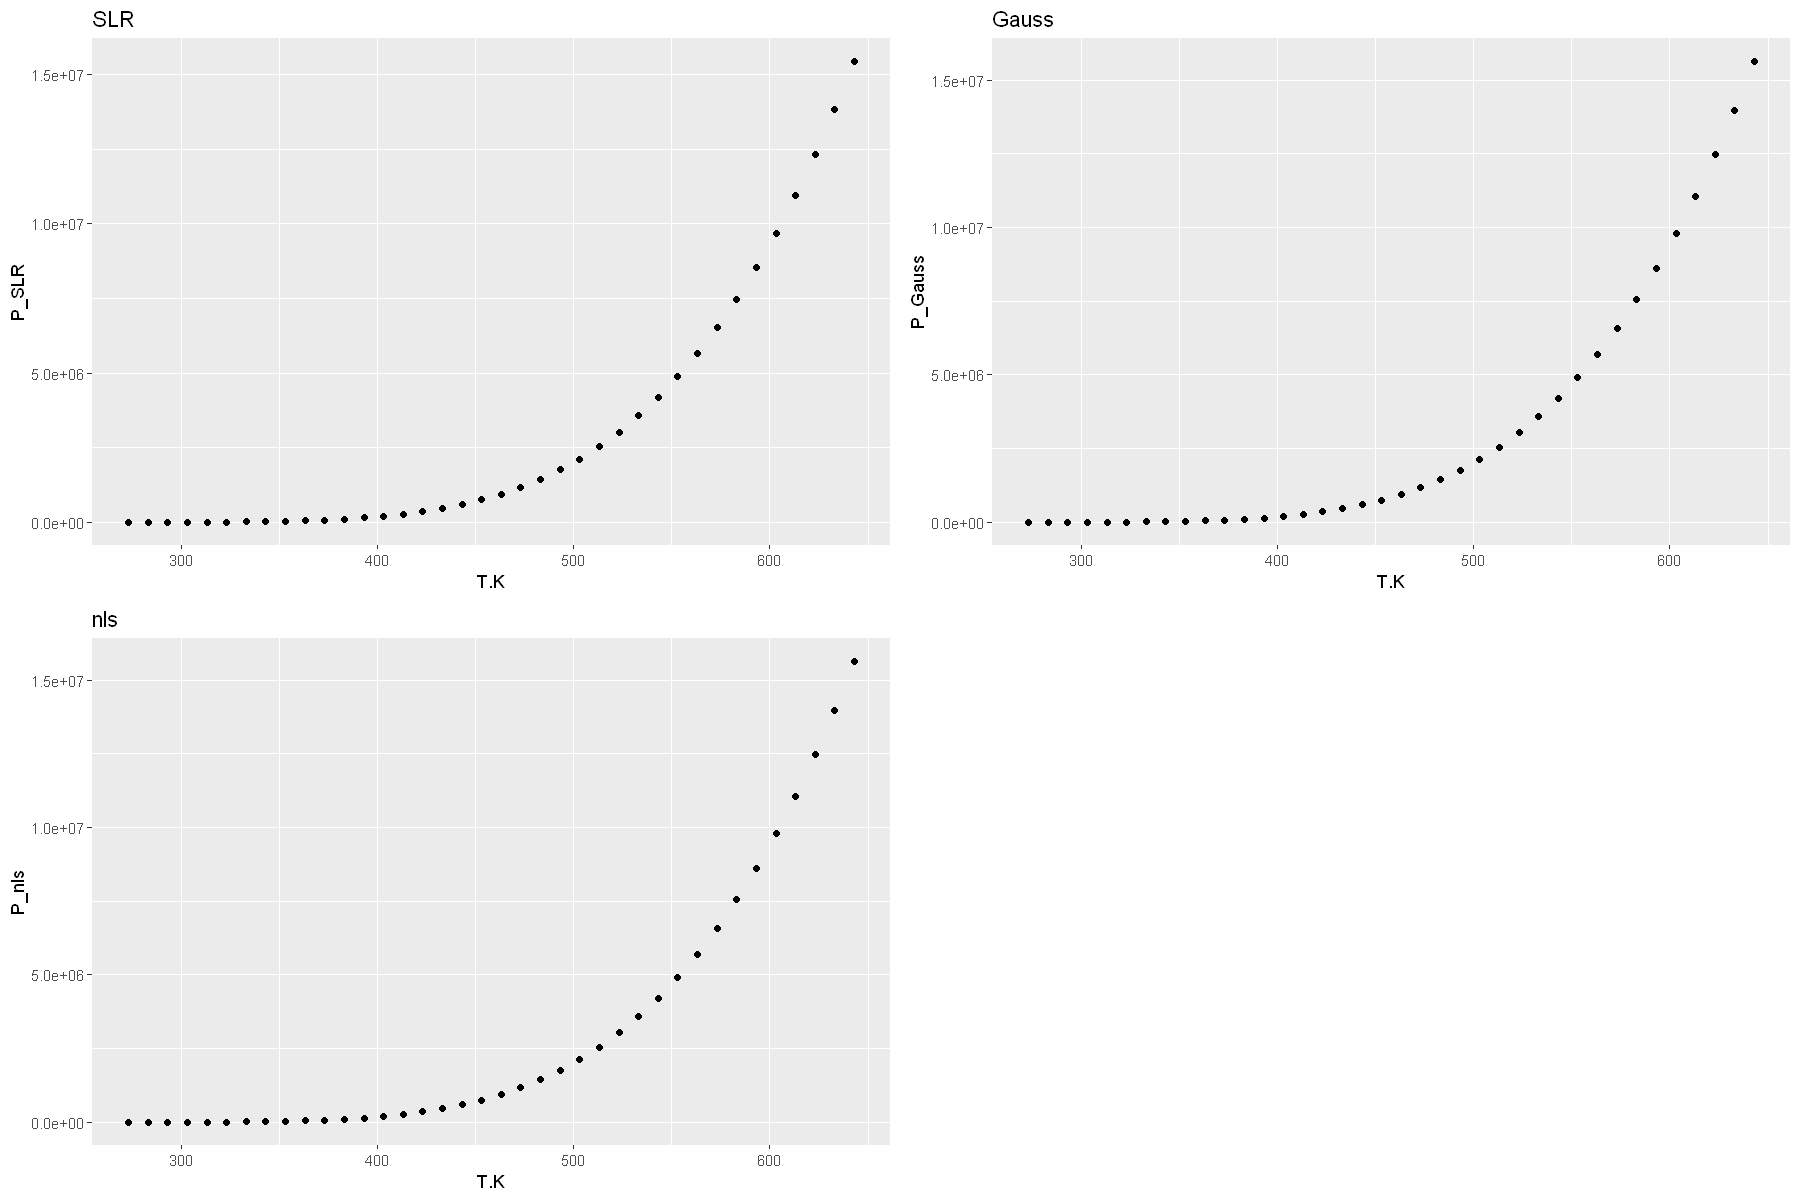

In [32]:
# (p,T)
data<-data %>% mutate(lnp_SLR=log(P_SLR),lnp_Corr=log(P_Corr),lnp_Gauss=log(P_Gauss),lnp_nls=log(P_nls))
g1 <- ggplot(data,aes(T.K,P_SLR))+geom_point()+ggtitle("SLR")
g2 <- ggplot(data,aes(T.K,P_Gauss))+geom_point()+ggtitle("Gauss")
g3 <- ggplot(data,aes(T.K,P_nls))+geom_point()+ggtitle("nls")

grid.arrange(g1,g2,g3, ncol=2)

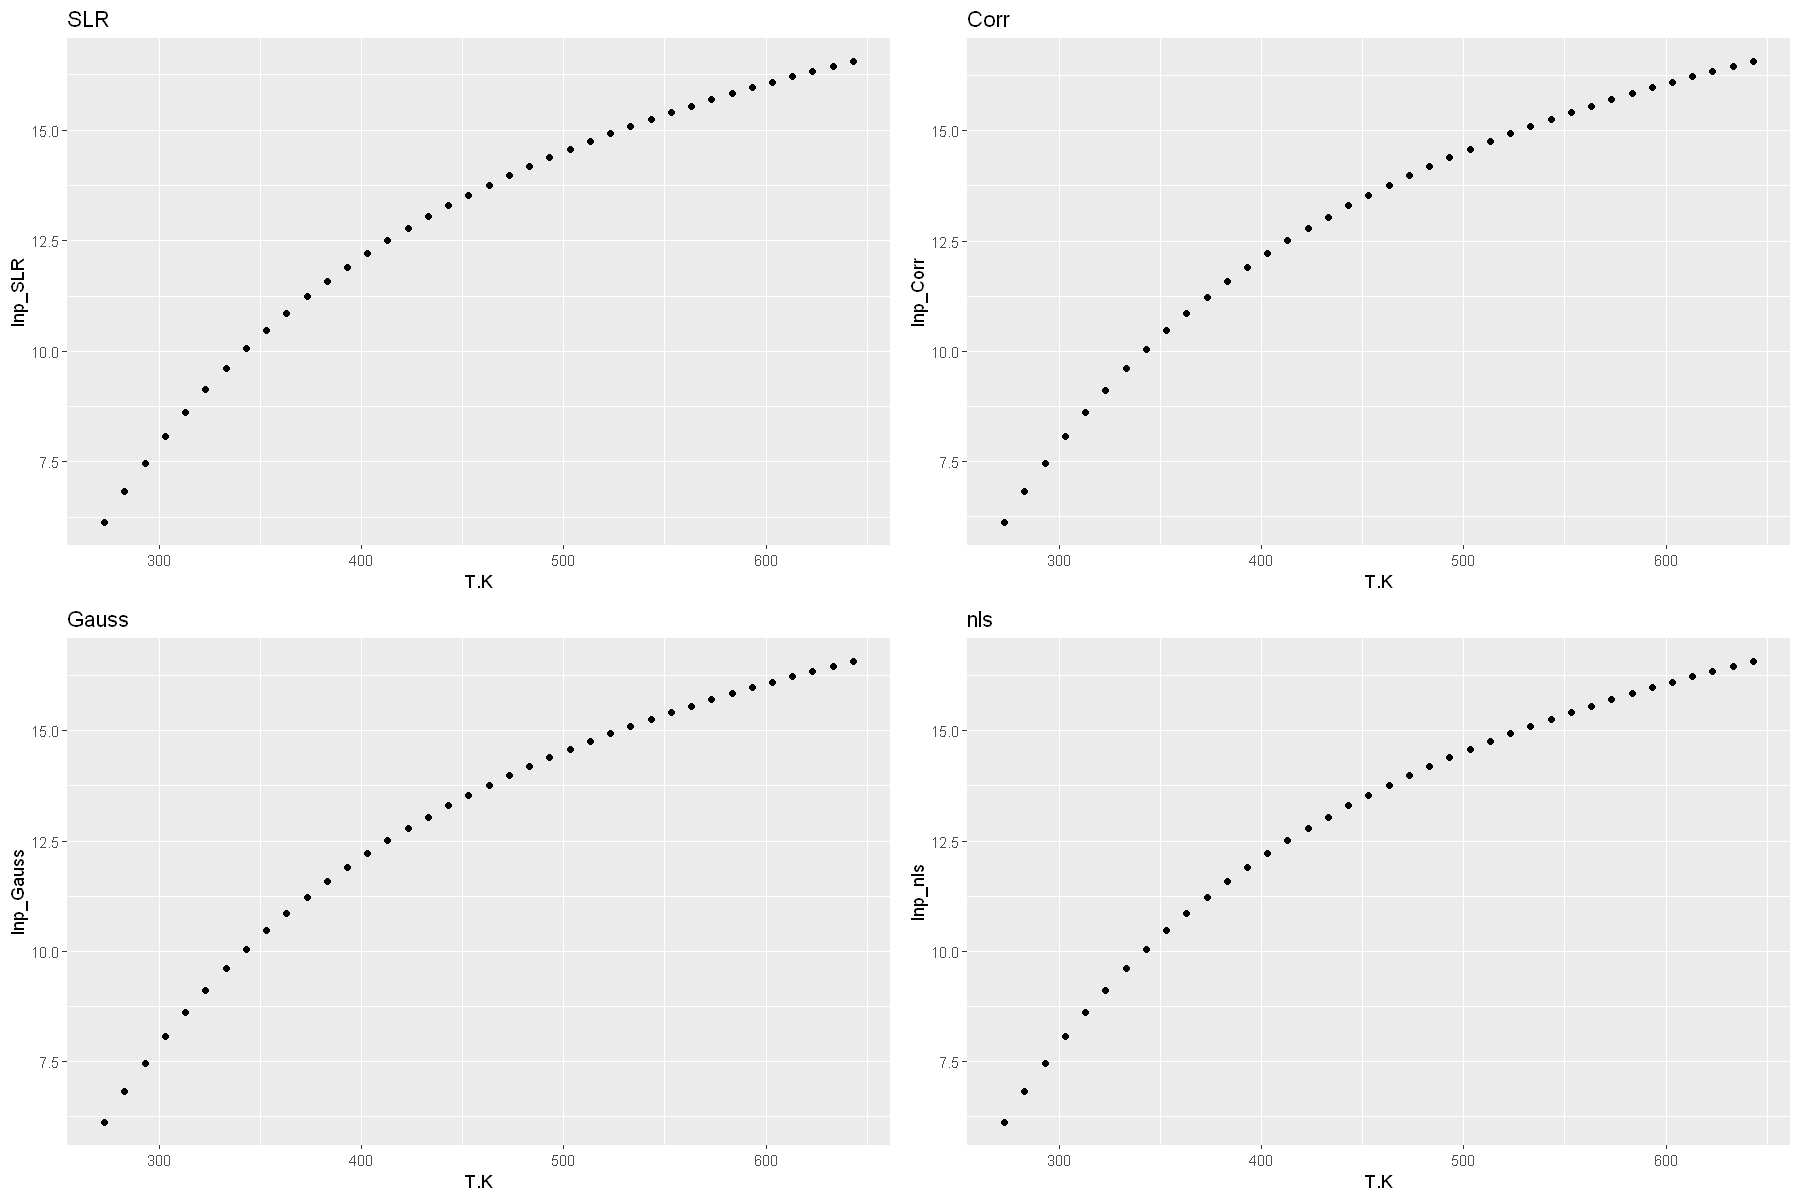

In [33]:
# (lnp, T)
g1 <- ggplot(data,aes(T.K,lnp_SLR))+geom_point()+ggtitle("SLR")
g2 <- ggplot(data,aes(T.K,lnp_Corr))+geom_point()+ggtitle("Corr")
g3 <- ggplot(data,aes(T.K,lnp_Gauss))+geom_point()+ggtitle("Gauss")
g4 <- ggplot(data,aes(T.K,lnp_nls))+geom_point()+ggtitle("nls")

grid.arrange(g1,g2,g3,g4, ncol=2)

## PART 3 : Mark-Recapture 방법을 이용한 하와이 타이거 상어의 성장곡선추정 
* $L_\infty$ : 상어의 평균 최대길이 (maximum length attained)
* k : 연성장률 (annual growth rate)


* **Von Bertalanffy Growth Model** : $dL(t) = k(L_\infty - L(t))dt$
* $L(t_2) = L_\infty - (L_\infty - L(t_1))e^{-k(t_2-t_1)}$


* $L_j = L(t_j)$ : $t_j$ 시점의 상어의 길이 (j=1,2)
* $t_1$ : mark date
* $t_2$ : recapture date 

In [35]:
growth<-read.csv("Recapture.csv")
colnames(growth) <- c("sex", "date", "recapdate", "liberty", "pcl1", "pcl2")
growth <- growth %>% transmute(sex=sex, t=liberty/365.25, pcl1=pcl1, pcl2=pcl2, y=(pcl2-pcl1)/t, x=(pcl2+pcl1)/2)

### (a) 성장곡선 모수 추정

In [37]:
lm_GH<-lm(y~x,data=growth)
lm_GH


Call:
lm(formula = y ~ x, data = growth)

Coefficients:
(Intercept)            x  
   115.1824      -0.4078  


In [38]:
alpha<-summary(lm_GH)$coefficients[1]
beta<-summary(lm_GH)$coefficients[2]
k<- -beta
Linf<-alpha/k
k; Linf #initial value : Gurlland and Holt

[1] 0.4077733

[1] 282.4667

In [39]:
# nls
nls_growth <- nls(pcl2~a-(a-pcl1)*exp(-b*t),data=growth,start=list(a=Linf,b=k))

Linf_nls<-summary(nls_growth)$coefficients[1]
k_nls<-summary(nls_growth)$coefficients[2]
Linf_nls; k_nls

[1] 283.3586

[1] 0.3607735

### (b) 타이거 상어의 성장곡선 

In [40]:
t0<-log(1-51.5/Linf_nls)/k_nls #L0=51.5 이용해 t0 추정
t0

[1] -0.5559875

In [41]:
options(repr.plot.width = 10, repr.plot.height = 10)

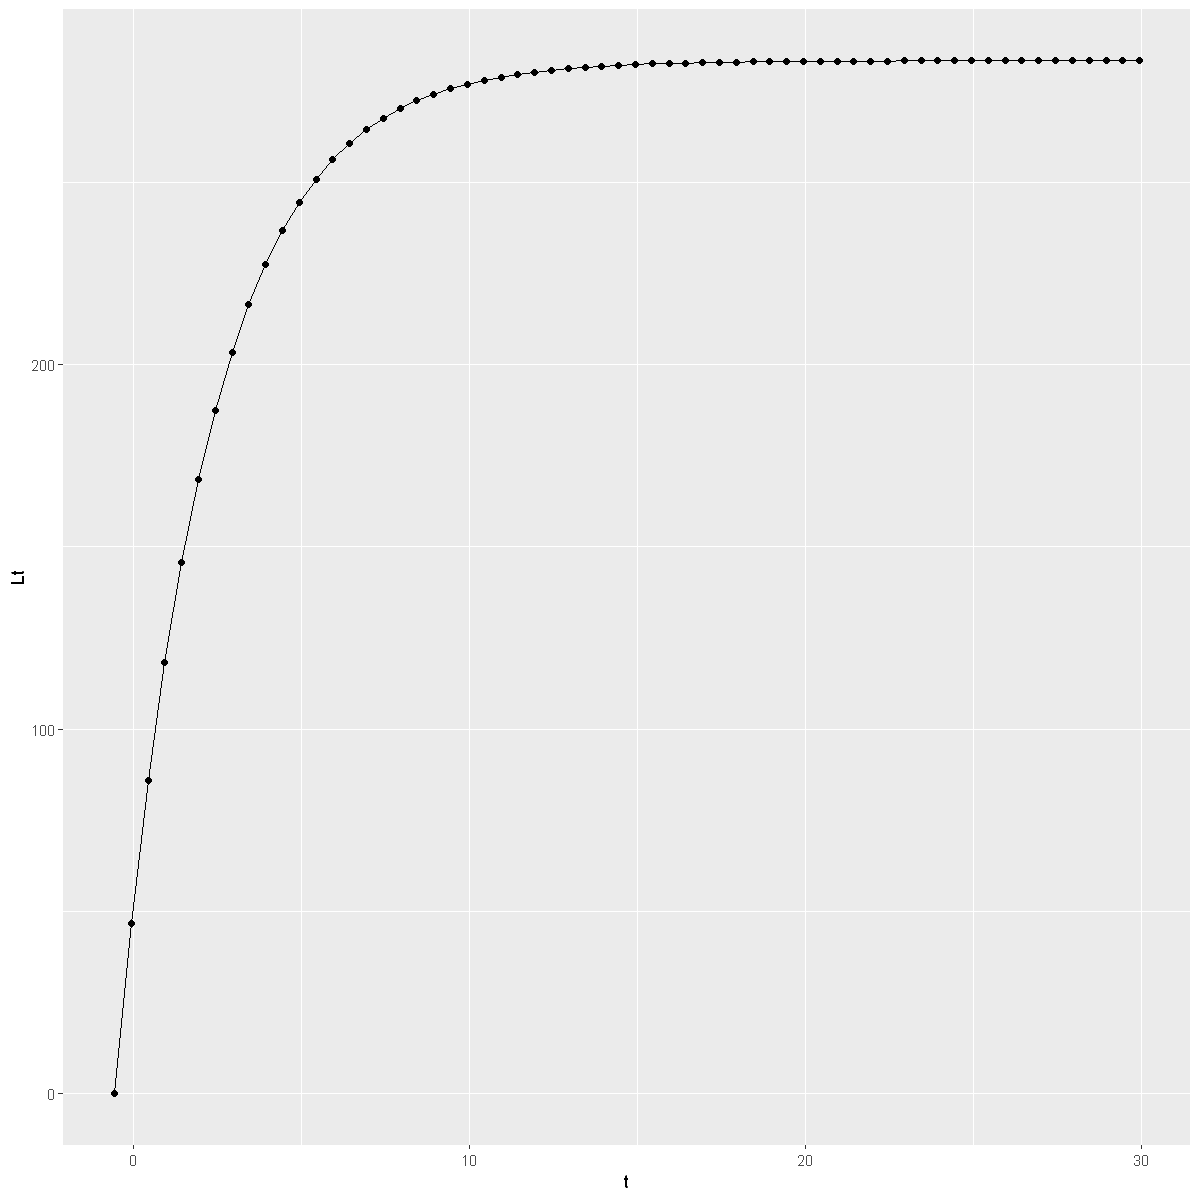

In [42]:
t<-seq(t0,30,by=0.5)
Lt<-c()

for (i in 1:length(t)) {
  Lt[i]<-Linf_nls*(1-exp(-k_nls*(t[i]-t0)))
}

ggplot(data.frame(t,Lt),aes(t,Lt))+geom_point()+geom_line()

### (c) 성별에 따른 성장곡선

#### Female

In [43]:
growth_F<-growth %>% filter(sex=="F")
growth_F<-growth_F %>% mutate(y=(pcl2-pcl1)/t,x=(pcl1+pcl2)/2)
lm_F<-lm(y~x,data=growth_F)
lm_F


Call:
lm(formula = y ~ x, data = growth_F)

Coefficients:
(Intercept)            x  
   111.9124      -0.3951  


In [44]:
alpha_F<-summary(lm_F)$coefficients[1]
beta_F<-summary(lm_F)$coefficients[2]
k_F<--beta_F
Linf_F<-alpha_F/k_F
k_F; Linf_F #initial value : Gurlland and Holt

[1] 0.3951209

[1] 283.2359

In [45]:
nls_growth_F<-nls(pcl2~a-(a-pcl1)*exp(-b*t),data=growth_F,start=list(a=Linf_F,b=k_F))
Linf_nls_F<-summary(nls_growth_F)$coefficients[1]
k_nls_F<-summary(nls_growth_F)$coefficients[2]
Linf_nls_F; k_nls_F

[1] 304.2591

[1] 0.2815061

#### Male

In [46]:
growth_M<-growth %>% filter(sex=="M")
growth_M<-growth_M %>% mutate(y=(pcl2-pcl1)/t,x=(pcl1+pcl2)/2)
lm_M<-lm(y~x,data=growth_M)
lm_M


Call:
lm(formula = y ~ x, data = growth_M)

Coefficients:
(Intercept)            x  
   131.7353      -0.4842  


In [47]:
alpha_M<-summary(lm_M)$coefficients[1]
beta_M<-summary(lm_M)$coefficients[2]
k_M<--beta_M
Linf_M<-alpha_M/k_M
k_M; Linf_M #initial value : Gurlland and Holt

[1] 0.4841781

[1] 272.0803

In [48]:
nls_growth_M<-nls(pcl2~a-(a-pcl1)*exp(-b*t),data=growth_M,start=list(a=Linf_M,b=k_M))
Linf_nls_M<-summary(nls_growth_M)$coefficients[1]
k_nls_M<-summary(nls_growth_M)$coefficients[2]
Linf_nls_M; k_nls_M

[1] 259.1021

[1] 0.5517073

In [49]:
t0_F<-log(1-51.5/Linf_nls_F)/k_nls_F #L0=51.5 이용해 t0 추정
t0_F

[1] -0.6587521

In [50]:
t0_M<-log(1-51.5/Linf_nls_M)/k_nls_M #L0=51.5 이용해 t0 추정
t0_M

[1] -0.4016603

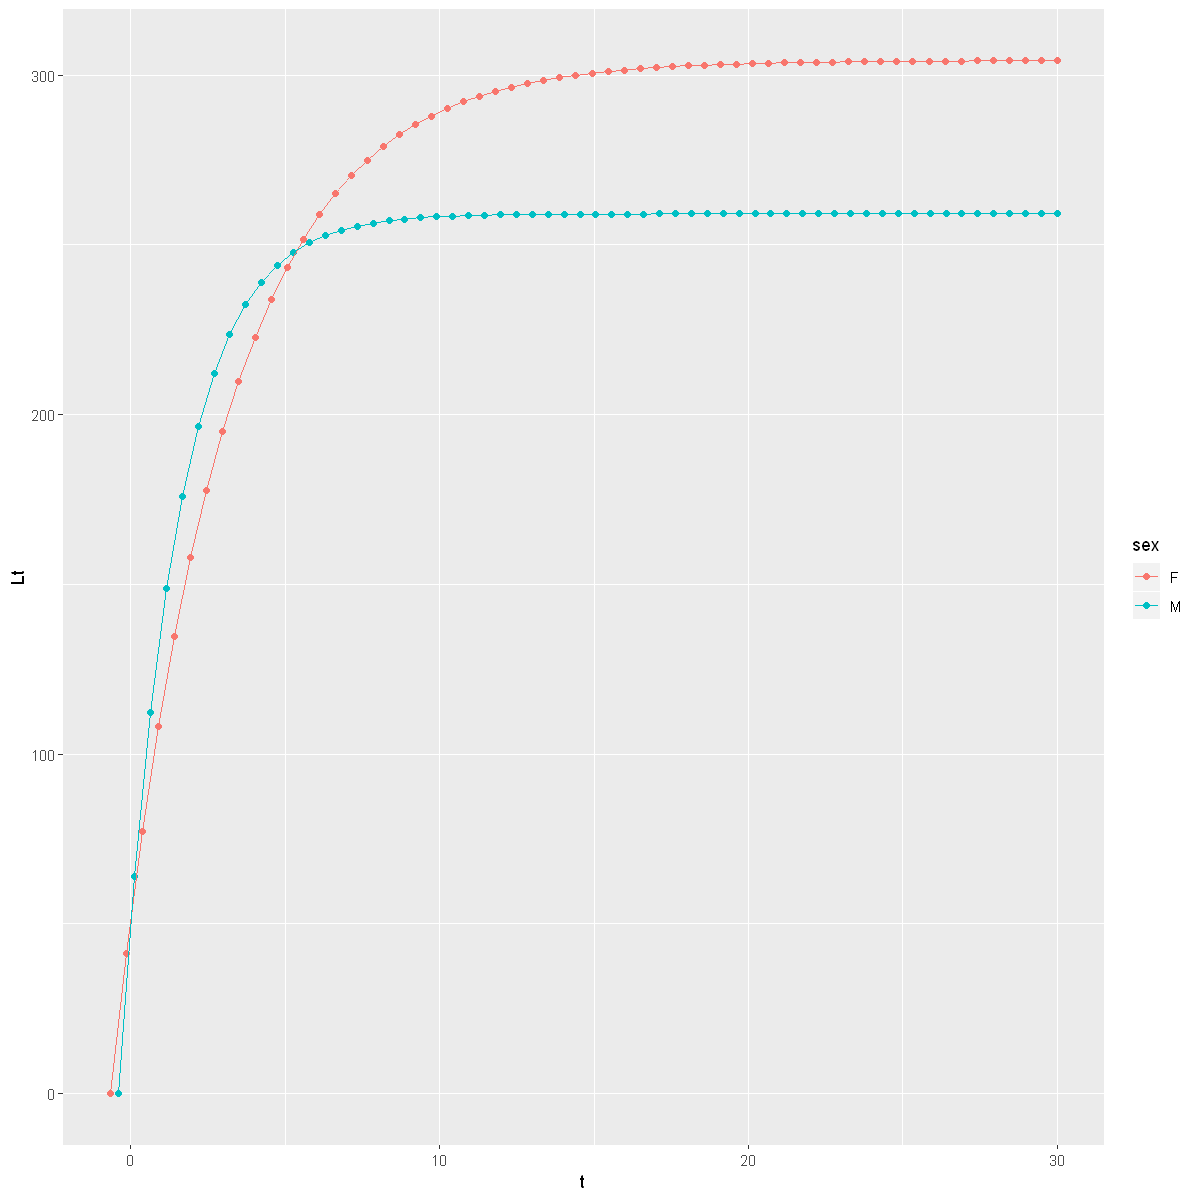

In [51]:
t_F<-seq(t0_F,30,length.out=60)
t_M<-seq(t0_M,30,length.out=60)
Lt_F<-c()
Lt_M<-c()

for (i in 1:length(t_F)) {
  Lt_F[i]<-Linf_nls_F*(1-exp(-k_nls_F*(t_F[i]-t0_F)))
  Lt_M[i]<-Linf_nls_M*(1-exp(-k_nls_M*(t_M[i]-t0_M)))
}

ggplot(data.frame(sex=c(rep("F",length(t_F)),rep("M",length(t_M))),t=c(t_F,t_M),Lt=c(Lt_F,Lt_M)),aes(t,Lt,colour=sex))+geom_point()+geom_line()

* 암수 모두 처음에는 급격히 성장하다가 서서히 성장하는 속도가 줄어든다. 
* t=5가 넘어서면 수컷 상어보다 암컷 상어의 길이가 더 길다는 경향을 보인다. 
* 따라서 두 그룹간 성장곡선에 차이가 있다고 할 수 있다.